#PYSPARK INSTALLATION

In [1]:
!pwd

/content


In [2]:
!apt-get update > /dev/null

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz > /dev/null

In [5]:
!tar -xvzf spark-3.2.1-bin-hadoop2.7.tgz > /dev/null

In [6]:
!pip install -q findspark > /dev/null

In [7]:
!pip install pyspark > /dev/null

In [8]:
!pip install pyecharts > /dev/null

In [9]:
!pip install ppscore > /dev/null

In [10]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

# findspark will locate spark in the system
import findspark
findspark.init()

In [11]:
#we have to import SparkSession from pyspark.sql
from  pyspark.sql  import SparkSession
spark = SparkSession.builder.appName('DataImputation').getOrCreate()

In [12]:
#trying to upload 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install --upgrade ipython > /dev/null

In [14]:
import ppscore as pps

#LOADING AND DISPLAYING THE DATA

In [15]:
data_df=spark.read.load('/content/drive/MyDrive/Tesi/db/observations')

#Data Preparation

In [17]:
import numpy as np
import json, codecs, sys
import pandas as pd
from pyspark.sql.functions import explode
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import substring, length, col, expr
from pyspark.sql.functions import sum, count, avg, stddev, count_distinct
import requests
from datetime import datetime
from pyspark.sql import functions as f
from pyspark.sql import functions as F
from pyspark.sql.functions import col

In [18]:
def component_code (code, nameColumn, whichCode = 'component_code_coding_code') :
  df = data_df.select(col('id'), col('subject_reference'), col('component_code_coding_code'),\
                      col('effectiveDateTime'), col('valueQuantity_value'), col('component_valueQuantity_value'),\
                      col('code_coding_code'), col('valueQuantity_value'))
  if whichCode == 'component_code_coding_code':
    BP_DATA = df.filter(df.component_code_coding_code == code)
  elif whichCode == 'code_coding_code':
    BP_DATA = df.filter(df.code_coding_code == code)
  BP = BP_DATA.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
  BP = BP.withColumn('unix_time', F.unix_timestamp(F.col('effectiveDateTime'), "yyyy-MM-dd"))
  BP = BP.withColumn('local_ts', F.date_format('effectiveDateTime', 'yyyy/MM/dd'))
  BP = BP.withColumn('local_date', F.date_trunc( 'day','effectiveDateTime')) 
  if whichCode == 'component_code_coding_code':
    BP_patient = BP.groupBy('local_date','Patient_id').agg(avg("component_valueQuantity_value").alias(nameColumn))
  elif whichCode == 'code_coding_code':
    BP_patient = BP.groupBy('local_date','Patient_id').agg(avg("valueQuantity_value").alias(nameColumn))
  each_patient = BP_patient.orderBy(f.col("local_date").asc())
  each_patient = each_patient.withColumn("ts",to_timestamp(col("local_date"))).withColumn("date",to_date(col("ts")))
  BP_PATIENT_DAILY = each_patient.select("date","Patient_id",nameColumn)
  return BP_PATIENT_DAILY

In [19]:
dfDiast = component_code("8454-1", "Diastolic pressure")
dfSisto = component_code("8460-8", "Systolic pressure")
dfHeart = component_code("8867-4", "Heart rate")
dfBeat = component_code("55425-3", "Heart beat", whichCode="code_coding_code")

In [20]:
dfBeat.show()

+----------+----------+----------+
|      date|Patient_id|Heart beat|
+----------+----------+----------+
|2021-10-28| 303827011|      67.0|
|2021-10-29| 303827011|      58.0|
|2021-10-30| 303827011|      54.0|
|2021-10-31| 303827011|      53.0|
|2021-11-01| 303827011|      44.0|
|2021-11-02| 303827011|      57.0|
|2021-11-03| 303827011|      68.0|
|2021-11-10|1411981309|       0.0|
|2021-11-10| 927744631|      80.0|
|2021-11-10| 621892226|      88.0|
|2021-11-11| 303827011|      77.0|
|2021-11-11| 593199858|      69.5|
|2021-11-11| 478893348|      70.0|
|2021-11-11|1411981309|       0.0|
|2021-11-11| 927744631|      71.0|
|2021-11-11| 621892226|      88.0|
|2021-11-12| 593199858|      67.5|
|2021-11-12|1411981309|       0.0|
|2021-11-12| 303827011|      79.0|
|2021-11-12|  32578327|      78.0|
+----------+----------+----------+
only showing top 20 rows



In [21]:
dfSteps = component_code("55423-8", "Steps", whichCode = 'code_coding_code')
dfSteps.show()

+----------+----------+------------------+
|      date|Patient_id|             Steps|
+----------+----------+------------------+
|2021-08-25| 927744631|              83.0|
|2021-10-25|1550736443|              44.0|
|2021-10-27| 303827011|               0.0|
|2021-10-28| 303827011|             173.0|
|2021-10-29| 303827011|               0.0|
|2021-10-30| 303827011|               0.0|
|2021-10-31| 303827011|               0.0|
|2021-11-01| 303827011|               0.0|
|2021-11-02| 303827011|               0.0|
|2021-11-03| 303827011|               0.0|
|2021-11-04| 303827011|              45.0|
|2021-11-10|1411981309|               0.0|
|2021-11-10| 621892226|               0.0|
|2021-11-10| 927744631|               0.0|
|2021-11-11|1411981309|               0.0|
|2021-11-11| 593199858|1226.3333333333333|
|2021-11-11| 303827011|            2668.0|
|2021-11-11| 478893348|            2302.0|
|2021-11-11| 621892226|               0.0|
|2021-11-11| 927744631|               0.0|
+----------

In [22]:
dfDiast.show()

+----------+----------+------------------+
|      date|Patient_id|Diastolic pressure|
+----------+----------+------------------+
|2021-10-25|1550736443|              78.0|
|2021-11-12| 303827011|              81.0|
|2021-11-12| 593199858|              69.5|
|2021-11-12|  32578327|              73.0|
|2021-11-12|1705741053|              69.0|
|2021-11-13|1411981309|              71.0|
|2021-11-13|1705741053|              75.0|
|2021-11-13|  32578327|              68.0|
|2021-11-13| 303827011|              94.0|
|2021-11-13| 593199858| 68.33333333333333|
|2021-11-14|1705741053|              74.0|
|2021-11-14|  32578327|              70.5|
|2021-11-15|  32578327|              76.0|
|2021-11-15|1411981309|              78.0|
|2021-11-15| 593199858|              57.0|
|2021-11-15| 568140626|              82.0|
|2021-11-16| 568140626|              86.0|
|2021-11-16|  32578327|              70.5|
|2021-11-16|1705741053|              78.0|
|2021-11-17| 792607756|              94.0|
+----------

In [23]:
dfSisto.show()

+----------+----------+------------------+
|      date|Patient_id| Systolic pressure|
+----------+----------+------------------+
|2021-10-25|1550736443|             115.0|
|2021-11-12| 303827011|             113.0|
|2021-11-12| 593199858|             113.0|
|2021-11-12|  32578327|             120.0|
|2021-11-12|1705741053|             128.0|
|2021-11-13|1411981309|             131.0|
|2021-11-13|1705741053|             125.0|
|2021-11-13|  32578327|             114.5|
|2021-11-13| 303827011|             132.0|
|2021-11-13| 593199858|110.66666666666667|
|2021-11-14|1705741053|             130.5|
|2021-11-14|  32578327|             107.5|
|2021-11-15|  32578327|             125.5|
|2021-11-15|1411981309|             122.0|
|2021-11-15| 593199858|             109.0|
|2021-11-15| 568140626|             118.0|
|2021-11-16| 568140626|             130.0|
|2021-11-16|  32578327|             114.0|
|2021-11-16|1705741053|             135.0|
|2021-11-17| 792607756|             129.0|
+----------

In [24]:
dfHeart.show()

+----------+----------+------------------+
|      date|Patient_id|        Heart rate|
+----------+----------+------------------+
|2021-10-25|1550736443|              65.0|
|2021-11-12| 303827011|              92.0|
|2021-11-12| 593199858|              63.0|
|2021-11-12|  32578327|              58.0|
|2021-11-12|1705741053|              68.0|
|2021-11-13| 303827011|              83.0|
|2021-11-13| 593199858|61.666666666666664|
|2021-11-13|  32578327|              54.5|
|2021-11-13|1705741053| 65.33333333333333|
|2021-11-14|  32578327|              61.5|
|2021-11-14|1705741053|              67.5|
|2021-11-15| 593199858|              52.0|
|2021-11-15|  32578327|              58.5|
|2021-11-15|1411981309|              63.0|
|2021-11-15| 568140626|              86.0|
|2021-11-16|1705741053|              75.0|
|2021-11-16| 568140626|              86.0|
|2021-11-16|  32578327|              57.5|
|2021-11-17|1705741053|              76.0|
|2021-11-17|  32578327|              67.5|
+----------

In [25]:
from pyspark.sql import DataFrame
from functools import reduce

In [26]:
def missingDates(df, nameColumn):
  list_patient = list(df.select('Patient_id').distinct().toPandas()['Patient_id'])
  df = df.withColumn('ts', F.unix_timestamp(F.col('date'), "yyyy-MM-dd"))
  DFlist_patient = []
  for i in range(len(list_patient)):
    DFlist_patient.append(df.filter(df.Patient_id == list_patient[i]))
  Result = []
  D = 86400 
  for G in range(len(DFlist_patient)) :
    M = DFlist_patient[G].groupBy('Patient_id').agg(max("ts").alias('ts')).first()['ts']
    Ma = DFlist_patient[G].groupBy('Patient_id').agg(min("ts").alias('ts')).first()['ts']
    l = [x for x in range(Ma, M+D, D)]
    DateDataFrame = spark.createDataFrame(pd.DataFrame({'ts': l}))
    d = DateDataFrame.withColumn("ts1", from_unixtime("ts")).withColumn("date",to_date(col("ts1")))
    date = d.select('date')
    K = DFlist_patient[G].join(date,'date',"right")
    DFlist_patient[G] = K.na.fill({'Patient_id': DFlist_patient[G].first()['Patient_id']})
    Result.append(DFlist_patient[G].select("date","Patient_id", nameColumn))
  BP_PATIENT_DAILY = reduce(DataFrame.union, Result)
  return BP_PATIENT_DAILY

In [27]:
dfDiast = missingDates(dfDiast, "Diastolic pressure")
dfSisto = missingDates(dfSisto, "Systolic pressure")
dfHeart = missingDates(dfHeart, "Heart rate")
dfBeat = missingDates(dfBeat, "Heart beat")

In [28]:
dfBeat.show()

+----------+----------+----------+
|      date|Patient_id|Heart beat|
+----------+----------+----------+
|2021-11-12|  32578327|      78.0|
|2021-11-13|  32578327|      66.0|
|2021-11-14|  32578327|      70.0|
|2021-11-15|  32578327|      72.0|
|2021-11-16|  32578327|      68.0|
|2021-11-17|  32578327|      null|
|2021-11-18|  32578327|      70.0|
|2021-11-19|  32578327|      69.0|
|2021-11-20|  32578327|      68.0|
|2021-11-21|  32578327|      71.0|
|2021-11-22|  32578327|      73.0|
|2021-11-23|  32578327|      74.0|
|2021-11-24|  32578327|      72.0|
|2021-11-25|  32578327|      69.0|
|2021-11-26|  32578327|      71.0|
|2021-11-27|  32578327|      74.0|
|2021-11-28|  32578327|      72.0|
|2021-11-29|  32578327|      76.0|
|2021-11-30|  32578327|      75.0|
|2021-12-01|  32578327|      69.0|
+----------+----------+----------+
only showing top 20 rows



In [29]:
dfSteps = missingDates(dfSteps, "Steps")

In [30]:
dfSteps.show()

+----------+----------+------------------+
|      date|Patient_id|             Steps|
+----------+----------+------------------+
|2021-11-22|1705741053|            3021.0|
|2021-11-12|  32578327|          12657.75|
|2021-11-13|  32578327|2864.6666666666665|
|2021-11-14|  32578327|            3660.0|
|2021-11-15|  32578327| 8040.142857142857|
|2021-11-16|  32578327| 4762.111111111111|
|2021-11-17|  32578327|3041.3333333333335|
|2021-11-18|  32578327|            4316.2|
|2021-11-19|  32578327|3988.3333333333335|
|2021-11-20|  32578327|            2083.0|
|2021-11-21|  32578327| 5773.857142857143|
|2021-11-22|  32578327|            4704.4|
|2021-11-23|  32578327|          6852.375|
|2021-11-24|  32578327|            3203.2|
|2021-11-25|  32578327|            4907.5|
|2021-11-26|  32578327|            3474.0|
|2021-11-27|  32578327|            3617.0|
|2021-11-28|  32578327|            3223.0|
|2021-11-29|  32578327|           2656.75|
|2021-11-30|  32578327|            5196.0|
+----------

In [31]:
dfDiast.show()

+----------+----------+------------------+
|      date|Patient_id|Diastolic pressure|
+----------+----------+------------------+
|2021-11-12|1705741053|              69.0|
|2021-11-13|1705741053|              75.0|
|2021-11-14|1705741053|              74.0|
|2021-11-15|1705741053|              null|
|2021-11-16|1705741053|              78.0|
|2021-11-17|1705741053|              82.0|
|2021-11-18|1705741053|              null|
|2021-11-19|1705741053|              null|
|2021-11-20|1705741053|              98.0|
|2021-11-21|1705741053|              null|
|2021-11-22|1705741053|              83.5|
|2021-11-23|1705741053|              86.0|
|2021-11-24|1705741053|              83.0|
|2021-11-25|1705741053|              null|
|2021-11-26|1705741053|              72.0|
|2021-11-27|1705741053|              null|
|2021-11-28|1705741053|              84.0|
|2021-11-29|1705741053|              null|
|2021-11-30|1705741053|              null|
|2021-12-01|1705741053|              null|
+----------

In [32]:
dfSisto.show()

+----------+----------+-----------------+
|      date|Patient_id|Systolic pressure|
+----------+----------+-----------------+
|2021-11-12|1705741053|            128.0|
|2021-11-13|1705741053|            125.0|
|2021-11-14|1705741053|            130.5|
|2021-11-15|1705741053|             null|
|2021-11-16|1705741053|            135.0|
|2021-11-17|1705741053|            141.0|
|2021-11-18|1705741053|             null|
|2021-11-19|1705741053|             null|
|2021-11-20|1705741053|            144.0|
|2021-11-21|1705741053|             null|
|2021-11-22|1705741053|            138.0|
|2021-11-23|1705741053|            134.0|
|2021-11-24|1705741053|            131.0|
|2021-11-25|1705741053|             null|
|2021-11-26|1705741053|            123.0|
|2021-11-27|1705741053|             null|
|2021-11-28|1705741053|            138.0|
|2021-11-29|1705741053|             null|
|2021-11-30|1705741053|             null|
|2021-12-01|1705741053|             null|
+----------+----------+-----------

In [33]:
dfHeart.show()

+----------+----------+-----------------+
|      date|Patient_id|       Heart rate|
+----------+----------+-----------------+
|2021-11-12|1705741053|             68.0|
|2021-11-13|1705741053|65.33333333333333|
|2021-11-14|1705741053|             67.5|
|2021-11-15|1705741053|             null|
|2021-11-16|1705741053|             75.0|
|2021-11-17|1705741053|             76.0|
|2021-11-18|1705741053|             null|
|2021-11-19|1705741053|             null|
|2021-11-20|1705741053|             69.0|
|2021-11-21|1705741053|             null|
|2021-11-22|1705741053|             73.5|
|2021-11-23|1705741053|             87.0|
|2021-11-24|1705741053|             85.0|
|2021-11-25|1705741053|             null|
|2021-11-26|1705741053|             75.0|
|2021-11-27|1705741053|             null|
|2021-11-28|1705741053|             72.0|
|2021-11-29|1705741053|             null|
|2021-11-30|1705741053|             null|
|2021-12-01|1705741053|             null|
+----------+----------+-----------

In [34]:
dfTot = dfDiast.join(dfSisto,['Patient_id','date'],'full')\
               .join(dfHeart,['Patient_id','date'],'full')\
               .join(dfBeat,['Patient_id','date'],'full')\
               .join(dfSteps,['Patient_id','date'],'full')

In [35]:
dfTot.show()

+----------+----------+------------------+-----------------+----------+----------+------------------+
|Patient_id|      date|Diastolic pressure|Systolic pressure|Heart rate|Heart beat|             Steps|
+----------+----------+------------------+-----------------+----------+----------+------------------+
|1065442966|2021-12-14|              null|             null|      null|      70.0|2523.3333333333335|
|1065442966|2021-12-15|              null|             null|      null|      74.0| 376.3333333333333|
|1065442966|2021-12-16|              null|             null|      null|      70.0|             301.5|
|1065442966|2021-12-17|              null|             null|      null|      76.0|2192.3333333333335|
|1065442966|2021-12-18|              null|             null|      null|      75.0|            1492.5|
|1065442966|2021-12-19|              null|             null|      null|      null|               0.0|
|1065442966|2021-12-20|              null|             null|      null|      79.0|

#Function to count data and correlation

In [36]:
def counter (col1, col2, df):
  df = df.toPandas()
  df = df[['Patient_id','date',col1, col2]]
  list_patient=list(df['Patient_id'].unique())
  DFlist_patient = []
  for i in range(len(list_patient)):                                                      
    DFlist_patient.append(df[df.Patient_id == list_patient[i]].dropna())
  Patients = []
  Counts = []
  Corr = []
  for x in DFlist_patient:
    C = len(x)
    if C != 0:
      P = x['Patient_id'].iloc[0]
      CR = x[col1].corr(x[col2])
    else:
      P = 'null'
      CR = 'null' 
    Patients.append(P)
    Counts.append(C)
    Corr.append(CR)
  countDict = pd.DataFrame({'Patient':Patients, 'Counter': Counts, 'Correlation': Corr})             
  return countDict

In [37]:
count1 = counter('Steps', 'Heart rate', dfTot)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [38]:
count1

,Patient,Counter,Correlation
0,1065442966,33,-0.142019
1,1411981309,6,-0.400707
2,1550736443,1,NaN
3,1705741053,1,NaN
4,null,0,null
5,303827011,89,-0.12786
6,32578327,37,-0.315457
7,457551051,7,0.432686
8,478893348,23,0.325588
9,512815964,56,0.415339


In [39]:
count2 = counter('Steps', 'Heart beat', dfTot)

In [40]:
count2

,Patient,Counter,Correlation
0,1065442966,77,0.118071
1,1411981309,64,0.333911
2,1550736443,103,0.118182
3,null,0,null
4,null,0,null
5,303827011,132,0.188174
6,32578327,65,0.392984
7,457551051,31,0.243301
8,478893348,62,-0.326376
9,512815964,57,0.511747


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error as mae
%matplotlib inline

In [42]:
def patientSelection (patient, df):
  df = df.filter(df.Patient_id == patient)
  return df
dfPatient = patientSelection("568140626", dfTot) #621892226, 32578327

In [43]:
dfPatient.show(150)

+----------+----------+------------------+------------------+----------+-----------------+------------------+
|Patient_id|      date|Diastolic pressure| Systolic pressure|Heart rate|       Heart beat|             Steps|
+----------+----------+------------------+------------------+----------+-----------------+------------------+
| 568140626|2021-11-15|              82.0|             118.0|      86.0|             75.0|             533.0|
| 568140626|2021-11-16|              86.0|             130.0|      86.0|             78.0|            2993.0|
| 568140626|2021-11-17|              86.0|             130.0|      80.0|             80.0|            1331.9|
| 568140626|2021-11-18|              85.0|             143.5|      41.0|             75.0|            1261.0|
| 568140626|2021-11-19|              82.0|             120.0|      91.0|             79.0|1002.3333333333334|
| 568140626|2021-11-20|              null|              null|      null|             75.0|1266.3333333333333|
| 56814062

#Correlation

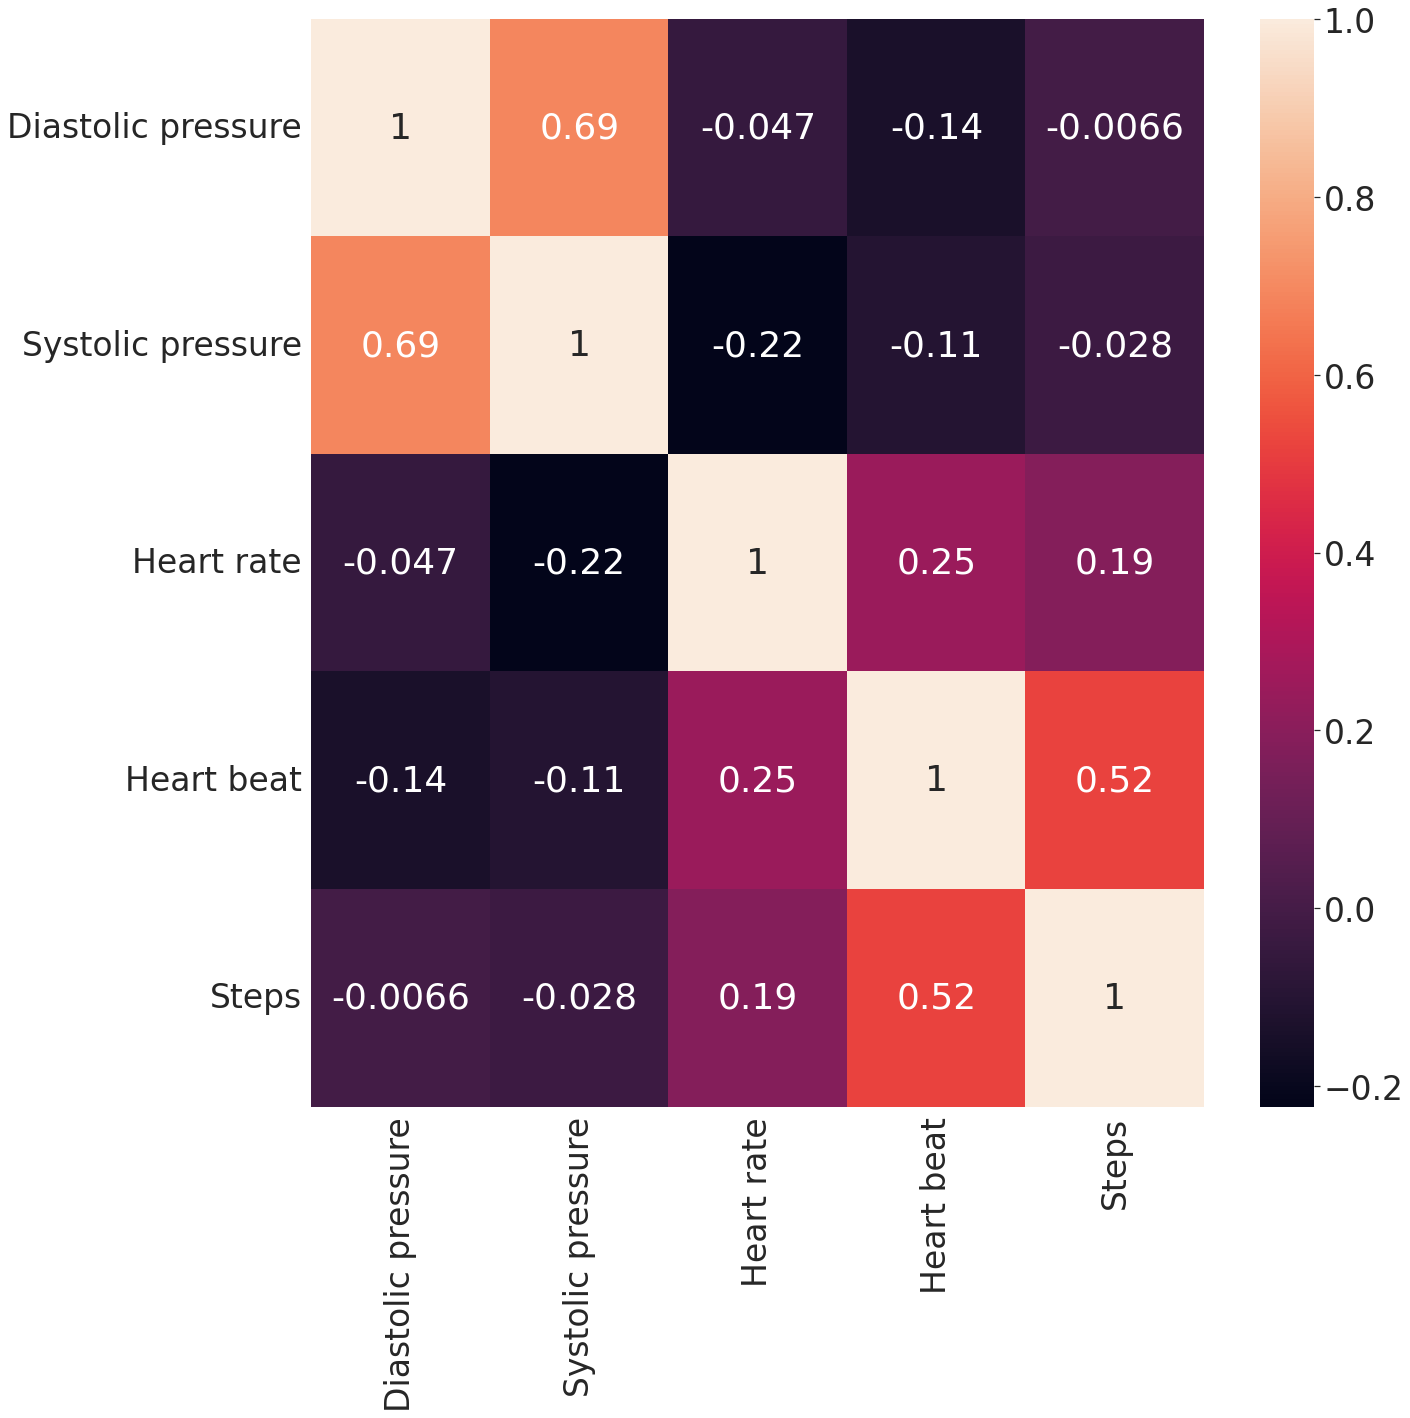

In [44]:
dfPandas = dfPatient.toPandas()
sns.set(font_scale = 3)
plt.figure(figsize=(20,20))
sns.heatmap(dfPandas.corr(), annot = True)
plt.show()

In [45]:
dfPandas.info()
dfPPS = dfPandas.drop(["Patient_id","date"], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Patient_id          141 non-null    object 
 1   date                141 non-null    object 
 2   Diastolic pressure  83 non-null     float64
 3   Systolic pressure   83 non-null     float64
 4   Heart rate          83 non-null     float64
 5   Heart beat          122 non-null    float64
 6   Steps               130 non-null    float64
dtypes: float64(5), object(2)
memory usage: 7.8+ KB


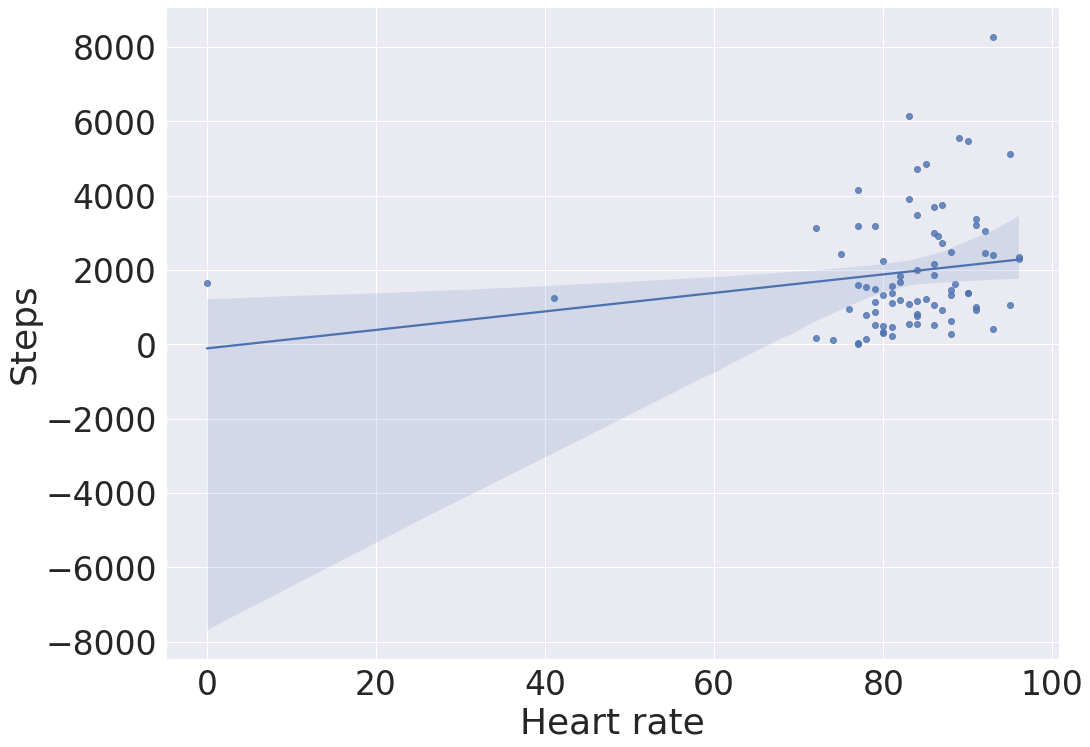

In [46]:
plt.figure(figsize=(16,12))
sns.regplot(data=dfPandas, x="Heart rate", y="Steps")
plt.show()

# PPS SCORE

In [47]:
pps.matrix(dfPPS)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Diastolic pressure,Diastolic pressure,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,Diastolic pressure,Systolic pressure,0.225609,regression,True,mean absolute error,11.405622,8.832415,DecisionTreeRegressor()
2,Diastolic pressure,Heart rate,0.000000,regression,True,mean absolute error,6.132530,10.637877,DecisionTreeRegressor()
3,Diastolic pressure,Heart beat,0.000000,regression,True,mean absolute error,2.782222,3.000012,DecisionTreeRegressor()
4,Diastolic pressure,Steps,0.000000,regression,True,mean absolute error,1173.496971,1621.815455,DecisionTreeRegressor()
5,Systolic pressure,Diastolic pressure,0.111327,regression,True,mean absolute error,4.857430,4.316667,DecisionTreeRegressor()
6,Systolic pressure,Systolic pressure,1.000000,predict_itself,True,None,0.000000,1.000000,None
7,Systolic pressure,Heart rate,0.000000,regression,True,mean absolute error,6.132530,9.493056,DecisionTreeRegressor()
8,Systolic pressure,Heart beat,0.000000,regression,True,mean absolute error,2.782222,4.112208,DecisionTreeRegressor()
9,Systolic pressure,Steps,0.000000,regression,True,mean absolute error,1173.496971,1347.719995,DecisionTreeRegressor()


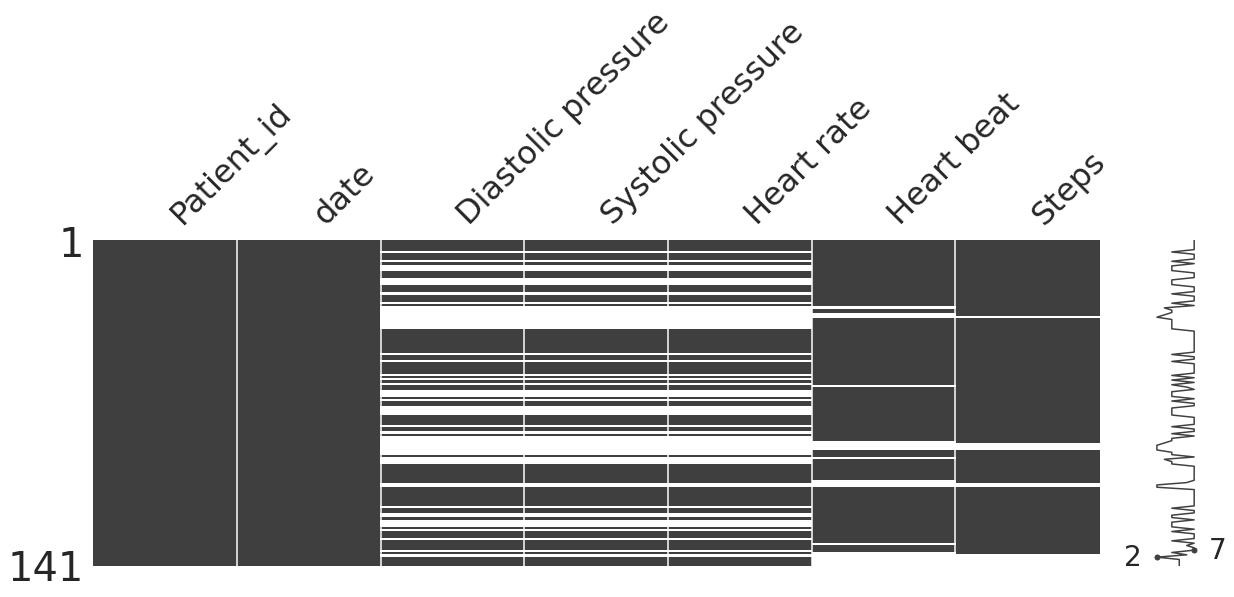

In [48]:
mno.matrix(dfPandas, figsize = (20, 6), fontsize =32)

#Data imputation functions

##Regression Imputation

In [49]:
def regressionImputation (dftot,random_state, plotting, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    np.random.seed(random_state)
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df
  for feature in missing_columns:
    dftot[feature + '_imp'] = dftot[feature]
    dftot = random_imputation(dftot, feature)

  deter_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      deter_data["Imputed_" + feature] = dftot[feature + "_imp"]
      parameters = list(set(dftot.columns) - set(missing_columns) - {feature + '_imp'})
      model = linear_model.LinearRegression()
      model.fit(X = dftot[parameters], y = dftot[feature + '_imp']) 
      deter_data.loc[dftot[feature].isnull(), "Imputed_" + feature] = model.predict(dftot[parameters])[dftot[feature].isnull()]
      
  else:
    missing_columns = str(missing_columns)[2:-2]
    deter_data["Imputed_" + missing_columns] = dftot[missing_columns + "_imp"]
    X = deter_data["Imputed_"+ missing_columns].to_numpy().reshape(-1,1)
    model = linear_model.LinearRegression()
    model.fit(X, y = dftot[missing_columns].fillna(method ='ffill')) 
    deter_data.loc[dftot[missing_columns].isnull(), "Imputed_" + missing_columns] = model.predict(X)[dftot[missing_columns].isnull()]
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(deter_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14, 14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(deter_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(deter_data["Imputed_" + variable], kde = True, ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("Linear Regression Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], deter_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(deter_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("Linear Regression Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], deter_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = deter_data["Imputed_" + x]

  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

##Stochastic Regression Imputation

In [50]:
def stochasticRegressionImputation (dftot,random_state = 51, plotting = True, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    np.random.seed(random_state)
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df
  for feature in missing_columns:
    dftot[feature + '_imp'] = dftot[feature]
    dftot = random_imputation(dftot, feature)

  random_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      random_data["Imputed_" + feature] = dftot[feature + '_imp']
      parameters = list(set(dftot.columns) - set(missing_columns) - {feature + '_imp'})
      model = linear_model.LinearRegression()
      model.fit(X = dftot[parameters], y = dftot[feature + '_imp']) 
      predict = model.predict(dftot[parameters])
      std_error = (predict[dftot[feature].notnull()] - dftot.loc[dftot[feature].notnull(), feature + '_imp']).std()
      random_predict = np.random.normal(size = dftot[feature].shape[0], 
                                        loc = predict, 
                                        scale = std_error)
      random_data.loc[(dftot[feature].isnull()) \
                      & (random_predict > 0), "Imputed_" + feature] =\
                       random_predict[(dftot[feature].isnull()) & (random_predict > 0)]                                                                      
  else:
    missing_columns = str(missing_columns)[2:-2]
    random_data["Imputed_" + missing_columns] = dftot[missing_columns + "_imp"]
    X = random_data["Imputed_" + missing_columns].to_numpy().reshape(-1,1)
    model = linear_model.LinearRegression()
    model.fit(X, y = dftot[missing_columns].fillna(method ='ffill')) 
    predict = model.predict(X)
    std_error = X.std()
    random_predict = np.random.normal(size = dftot[missing_columns].shape[0], 
                                        loc = predict, 
                                        scale = std_error)
    random_data.loc[(dftot[missing_columns].isnull()) &\
                    (random_predict > 0), "Imputed_" + missing_columns] = \
                    random_predict[(dftot[missing_columns].isnull()) & (random_predict > 0)]   
    
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(random_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14, 14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(random_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(random_data["Imputed_" + variable], kde = True, \
                     ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("Stochastic Regression Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], random_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(random_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("Stochastic Regression Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], random_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
     
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = random_data["Imputed_" + x]
  
  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

##Random Forests Imputation

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
def randomForestImputation (dftot,random_state, plotting, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    np.random.seed(random_state)
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df
  for feature in missing_columns:
    dftot[feature + '_imp'] = dftot[feature]
    dftot = random_imputation(dftot, feature)

  deter_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      deter_data["Imputed_" + feature] = dftot[feature + "_imp"]
      parameters = list(set(dftot.columns) - set(missing_columns) - {feature + '_imp'})
      model = RandomForestRegressor(n_estimators = 130, random_state=random_state)
      model.fit(X = dftot[parameters], y = dftot[feature + '_imp']) 
      deter_data.loc[dftot[feature].isnull(), "Imputed_" + feature] = model.predict(dftot[parameters])[dftot[feature].isnull()]
      
  else:
    missing_columns = str(missing_columns)[2:-2]
    deter_data["Imputed_" + missing_columns] = dftot[missing_columns + "_imp"]
    X = deter_data["Imputed_"+ missing_columns].to_numpy().reshape(-1,1)
    model = RandomForestRegressor(n_estimators = 130, random_state=random_state)
    model.fit(X, y = dftot[missing_columns].fillna(method ='ffill')) 
    deter_data.loc[dftot[missing_columns].isnull(), "Imputed_" + missing_columns] = model.predict(X)[dftot[missing_columns].isnull()]
    missing_columns = [missing_columns]
  
  if plotting == True:
    mno.matrix(deter_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14, 14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(deter_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(deter_data["Imputed_" + variable], kde = True, ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("Random Forests Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], deter_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(deter_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("Random Forests Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], deter_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = deter_data["Imputed_" + x]
  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

##XGBOOST Imputation

In [53]:
import xgboost as xgb

In [54]:
def xgboostImputation (dftot,random_state, plotting, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    np.random.seed(random_state)
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df
  for feature in missing_columns:
    dftot[feature + '_imp'] = dftot[feature]
    dftot = random_imputation(dftot, feature)

  deter_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      deter_data["Imputed_" + feature] = dftot[feature + "_imp"]
      parameters = list(set(dftot.columns) - set(missing_columns) - {feature + '_imp'})
      model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=random_state)
      model.fit(X = dftot[parameters], y = dftot[feature + '_imp']) 
      deter_data.loc[dftot[feature].isnull(), "Imputed_" + feature] = model.predict(dftot[parameters])[dftot[feature].isnull()]
      
  else:
    missing_columns = str(missing_columns)[2:-2]
    deter_data["Imputed_" + missing_columns] = dftot[missing_columns + "_imp"]
    X = deter_data["Imputed_" + missing_columns].to_numpy().reshape(-1,1)
    model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state=random_state)
    model.fit(X, y = dftot[missing_columns].fillna(method ='ffill')) 
    deter_data.loc[dftot[missing_columns].isnull(), "Imputed_" + missing_columns] = model.predict(X)[dftot[missing_columns].isnull()]
    missing_columns = [missing_columns]
  
  if plotting == True:
    mno.matrix(deter_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14, 14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(deter_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(deter_data["Imputed_" + variable], kde = True, ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("Xboost Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], deter_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(deter_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("Xboost Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], deter_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = deter_data["Imputed_" + x]
  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

##MICE Imputation


In [55]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [56]:
def MICEImputation (dftot,random_state, plotting, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  deter_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      deter_data["Imputed_" + feature] = dftot[feature]
    model = IterativeImputer(\
                               estimator = linear_model.LinearRegression(),\
                               verbose = 2, max_iter=50, tol=1e-10,\
                               imputation_order='roman'\
                            )
    model.fit(X = dftot) 
    deter_data = pd.DataFrame(model.transform(dftot), columns = deter_data.columns)
      
  else:
    missing_columns = str(missing_columns)[2:-2]
    deter_data["Imputed_" + missing_columns] = dftot[missing_columns]
    model = model = IterativeImputer(\
                          estimator = linear_model.LinearRegression(),\
                          verbose = 2, max_iter=30, tol=1e-10,\
                          imputation_order='roman')
    model.fit(X = dftot) 
    deter_data = pd.DataFrame(model.transform(dftot), columns = deter_data.columns)
    missing_columns = [missing_columns]
  
  if plotting == True:
    mno.matrix(deter_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14, 14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(deter_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(deter_data["Imputed_" + variable], kde = True, ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("MICE Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], deter_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(deter_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("MICE Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], deter_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = deter_data["Imputed_" + x]
  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

## Miss Forest Imputation

In [57]:
!pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.6 MB/s 


In [58]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [59]:
def MissForestImputation (dftot,random_state, plotting, *missing_columns):
  dfOriginal = dftot.toPandas().copy()
  missing_columns = list(missing_columns)
  if len(missing_columns) != 1:
    dftot = dftot.toPandas()[missing_columns]
  else:
    missing_columns = str(missing_columns)[2:-2] 
    dftot = pd.DataFrame(dftot.toPandas()[missing_columns])
    missing_columns = [missing_columns]

  if plotting == True:
    mno.matrix(dftot, figsize = (10, 10), fontsize=22)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      fig, axes = plt.subplots(nrows = 1, ncols = 1)
      fig.set_size_inches(14, 14)
      sns.heatmap(dftot.corr(), annot = True)
      plt.tight_layout()

  deter_data = pd.DataFrame(columns = ["Imputed_" + name for name in missing_columns])
  if len(missing_columns) != 1:
    for feature in missing_columns:  
      deter_data["Imputed_" + feature] = dftot[feature]
    model = MissForest()
    model.fit(X = dftot) 
    deter_data = pd.DataFrame(model.transform(dftot), columns = deter_data.columns)
      
  else:
    missing_columns = str(missing_columns)[2:-2]
    deter_data["Imputed_" + missing_columns] = dftot[missing_columns]
    model = model =MissForest()
    model.fit(X = dftot) 
    deter_data = pd.DataFrame(model.transform(dftot), columns = deter_data.columns)
    missing_columns = [missing_columns]
  
  if plotting == True:
    mno.matrix(deter_data, figsize = (10, 10), fontsize=22)
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(14,14)
    if len(missing_columns) != 1:
      sns.set(font_scale = 3)
      sns.heatmap(deter_data.corr(), annot = True)
    if len(missing_columns) != 1:
      sns.set(font_scale = 1)
      fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
      fig.set_size_inches(16, 16)
      for index, variable in enumerate(missing_columns):
        sns.set(font_scale = 1)
        sns.histplot(dftot[variable].dropna(), kde = True, ax = axes[index, 0], linewidth=0)
        sns.set(font_scale = 1)
        sns.histplot(deter_data["Imputed_" + variable], kde = True, ax = axes[index, 0], color = 'red', linewidth=0, legend = True)\
        .legend(labels=[variable,'Imputed_'+ variable]).set_title("Miss Forest Imputation")
        sns.set(font_scale = 1)
        sns.boxplot(data = pd.concat([dftot[variable], deter_data["Imputed_" + variable]], axis = 1),
                    ax = axes[index, 1])
      
      plt.tight_layout() 
    else:
      missing_columns = str(missing_columns)[2:-2]
      sns.set(font_scale = 1)
      sns.histplot(dftot[missing_columns].dropna(), kde = True, linewidth=0)
      sns.set(font_scale = 1)
      sns.histplot(deter_data["Imputed_" + missing_columns], kde = True, color = 'red', linewidth=0) 
      plt.legend(labels=[missing_columns,"Imputed_" + missing_columns]).set_title("Miss Forest Imputation")
      plt.show()
      sns.set(font_scale = 1)
      sns.boxplot(data = pd.concat([dftot[missing_columns], deter_data["Imputed_" + missing_columns]], axis = 1))
      plt.show()
      missing_columns = [missing_columns]
  dfOri = pd.DataFrame(columns = [name for name in missing_columns])
  for x in missing_columns:
    dfOri[x] = deter_data["Imputed_" + x]
  dfOriginal = dfOriginal.drop(missing_columns, axis = 1)
  dfImp = spark.createDataFrame(dfOriginal.join(dfOri))
  dfImp = dfImp.replace(float('nan'), None)
  return dfImp

#Imputation testing (Heart beat (with missing data) | Steps)
##Correlation = 0.52 Preimputation

##Data Preparation for testing

In [60]:
dfTest = dfTot.select(col('Patient_id'), col('date'), col('Heart beat'), col('Steps')).dropna()
dfTest = patientSelection("568140626", dfTest) #621892226, 32578327, 303827011

In [61]:
dforiginal = dfTest.toPandas()

In [62]:
import random
def fakeMissData (column, df, random_state = 51, percentage = 20):
  dfPanTest = df.toPandas()
  percent = int((len(dfPanTest)/100) * percentage)
  random.seed(random_state)
  r = random.sample(range(len(dfPanTest)),percent)
  dfPanTest[column] = [val if i not in r else np.nan for i, val in enumerate(dfPanTest[column])]
  dfPanTest = spark.createDataFrame(dfPanTest)
  return dfPanTest

##Testing with 10% of missing data

In [63]:
dfTestTenPercent = fakeMissData('Heart beat', dfTest,5,10)

In [64]:
dfTestTenPercent.show(150)

+----------+----------+-----------------+------------------+
|Patient_id|      date|       Heart beat|             Steps|
+----------+----------+-----------------+------------------+
| 568140626|2021-11-15|             75.0|             533.0|
| 568140626|2021-11-16|             78.0|            2993.0|
| 568140626|2021-11-17|             80.0|            1331.9|
| 568140626|2021-11-18|              NaN|            1261.0|
| 568140626|2021-11-19|             79.0|1002.3333333333334|
| 568140626|2021-11-20|             75.0|1266.3333333333333|
| 568140626|2021-11-21|             74.0|             216.0|
| 568140626|2021-11-22|             81.0|            3372.5|
| 568140626|2021-11-23|             77.0| 867.2857142857143|
| 568140626|2021-11-24|             77.0| 846.3333333333334|
| 568140626|2021-11-25|             78.0|2152.3333333333335|
| 568140626|2021-11-26|             74.0|            2420.0|
| 568140626|2021-11-27|             82.0|3741.3333333333335|
| 568140626|2021-11-28| 

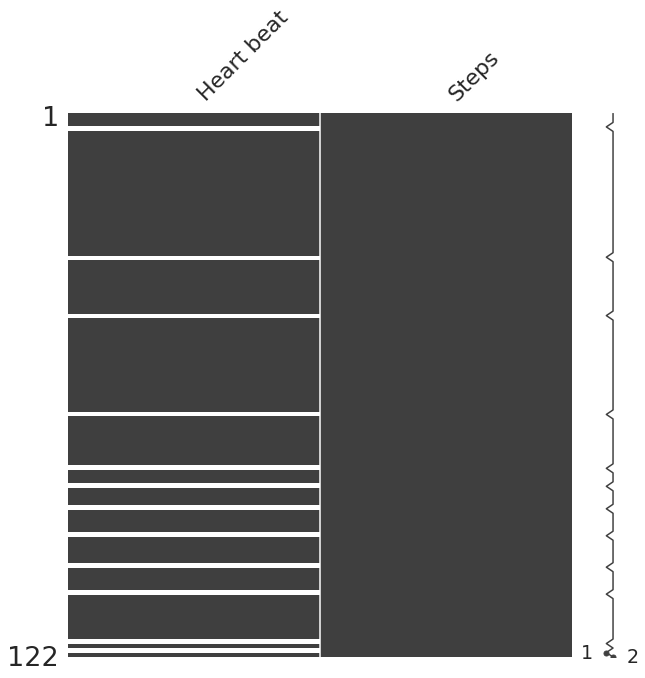

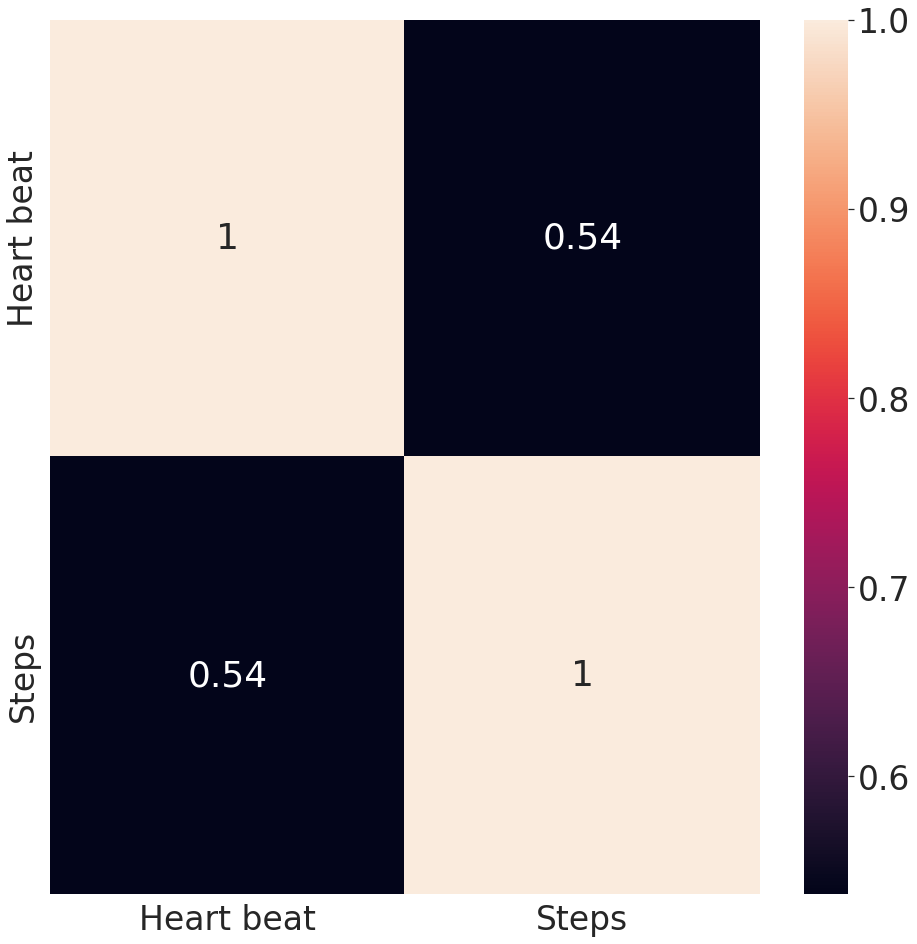

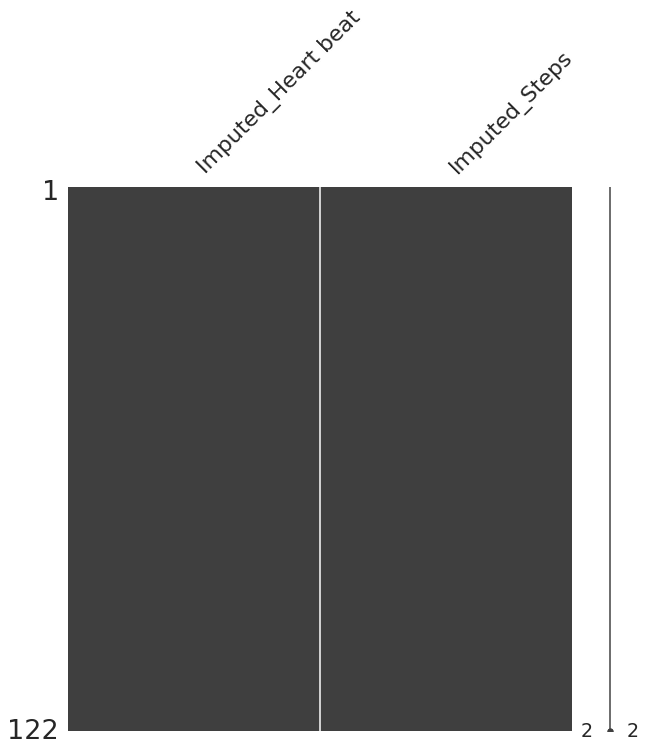

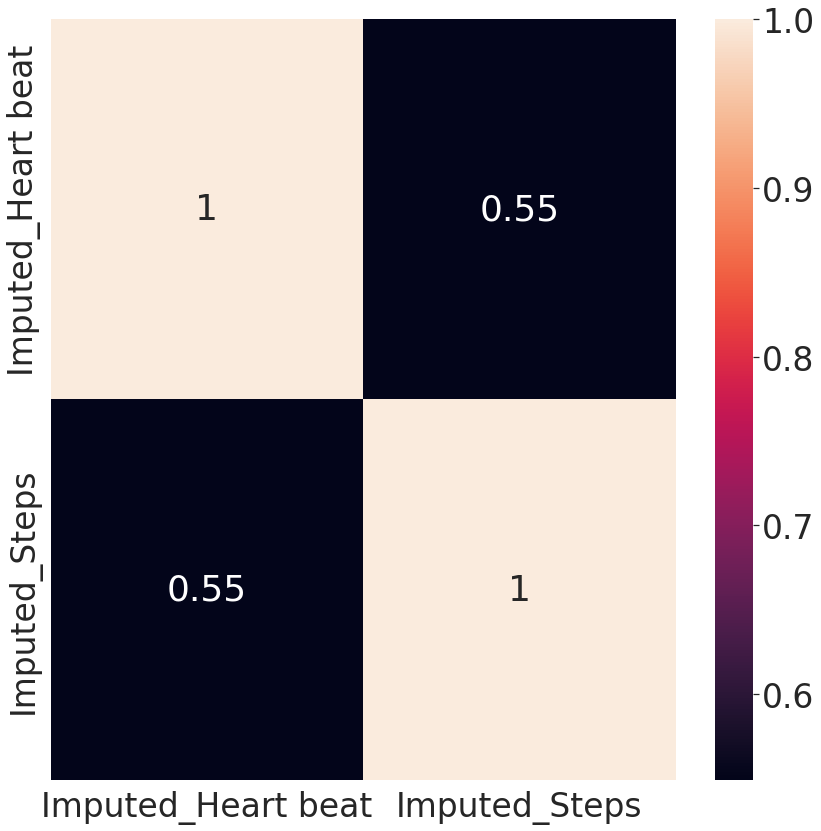

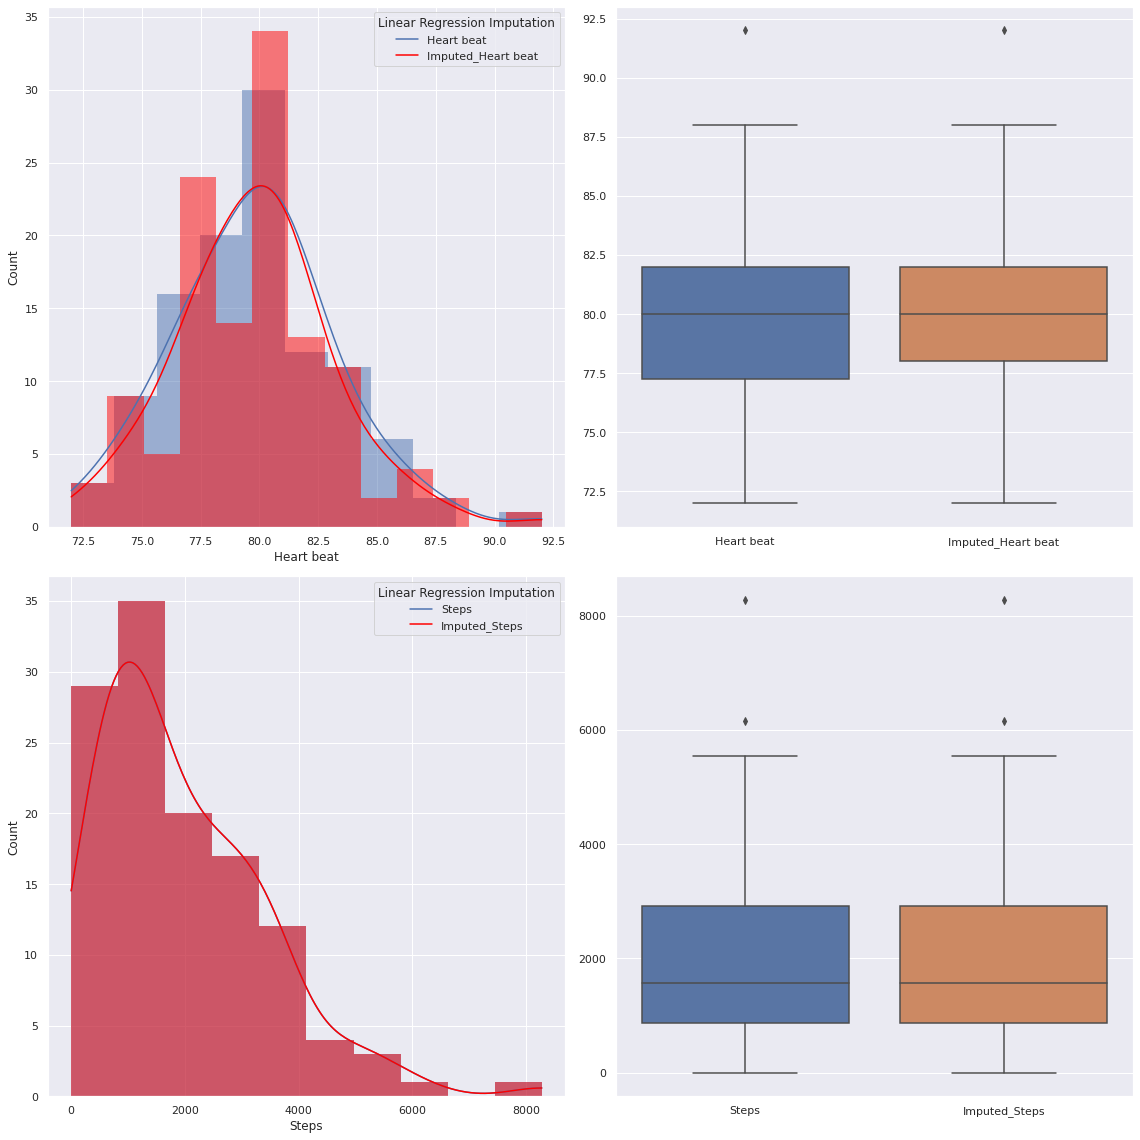

In [65]:
dfRegressionTest10 = regressionImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [66]:
dfRegressionTest10

3      78.975342
32     80.997669
45     78.740162
67     81.042043
79     77.576465
83     81.512773
88     78.110797
94     81.106015
101    78.865518
107    80.710350
118    77.717351
120    79.100698
Name: Heart beat, dtype: float64

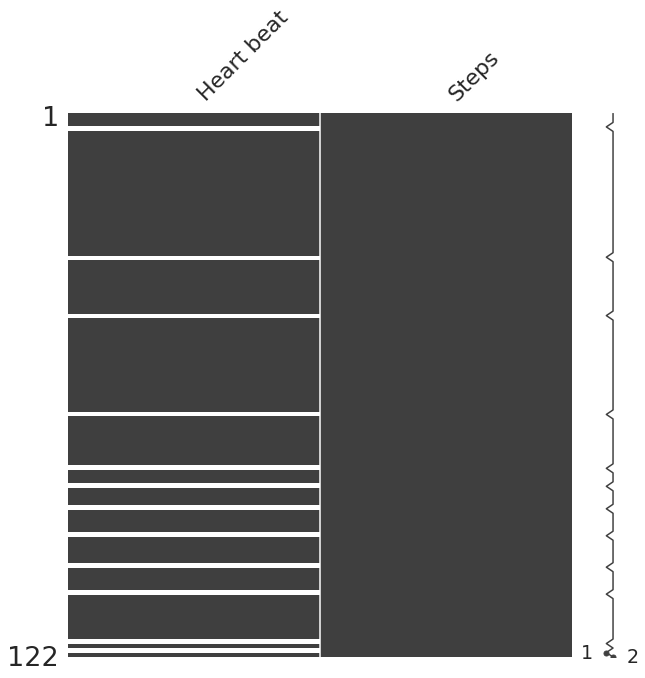

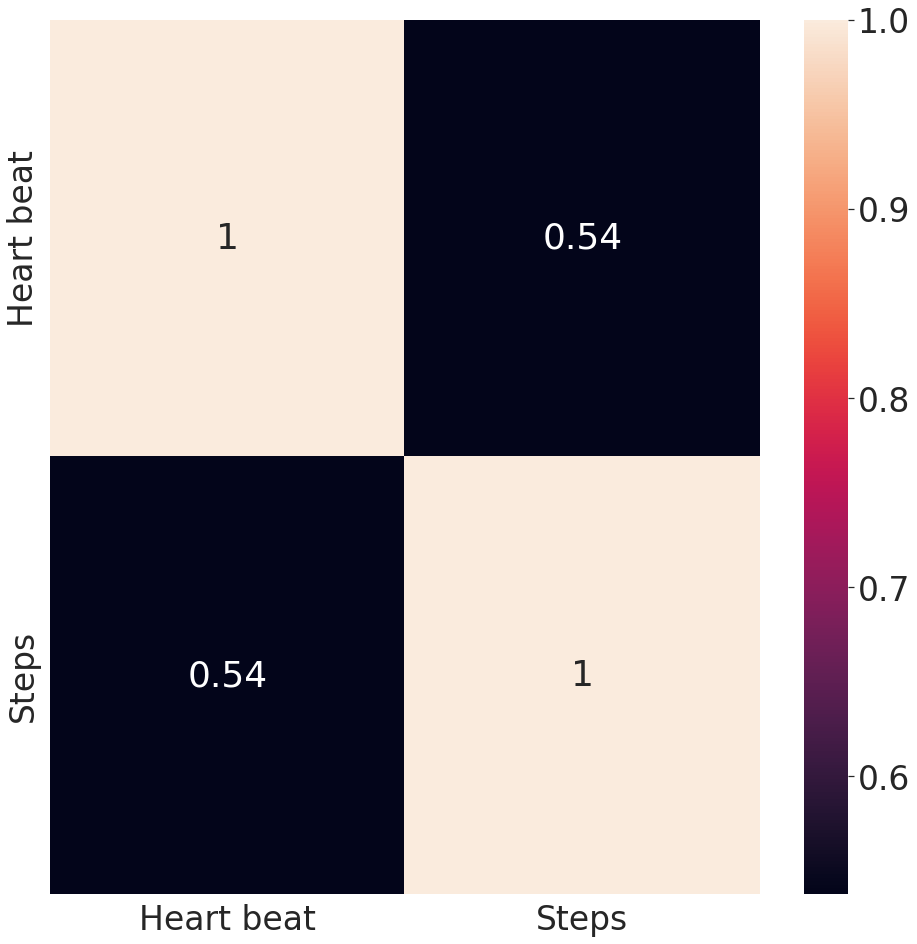

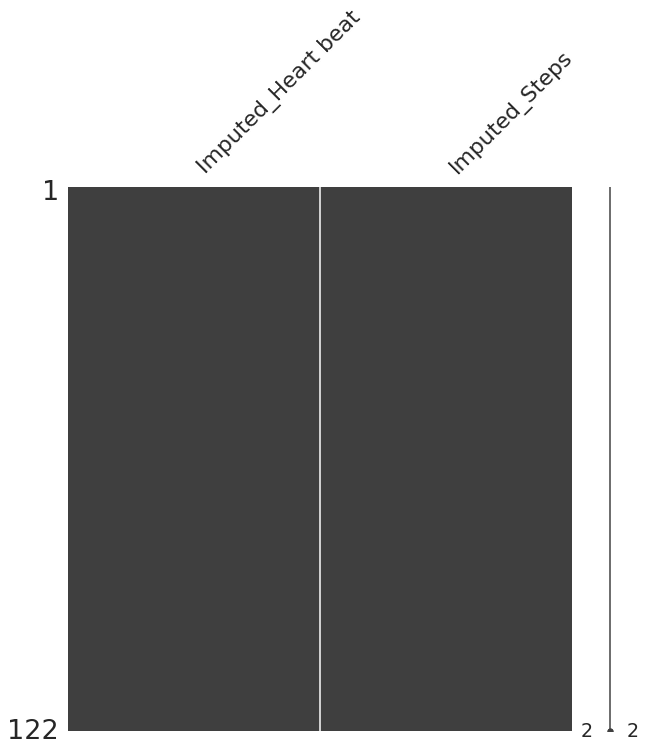

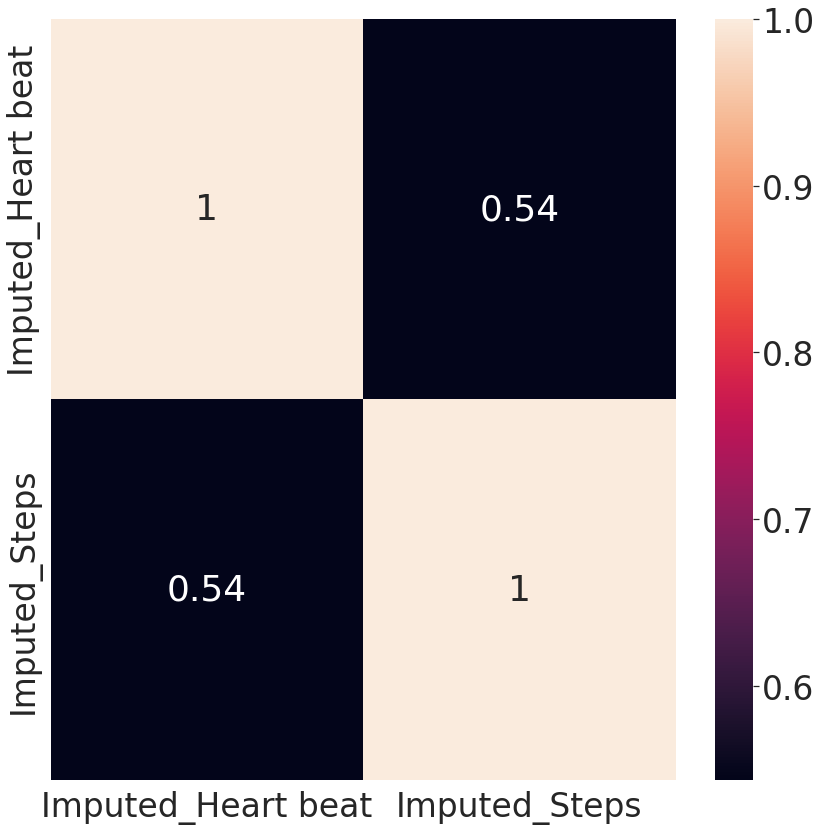

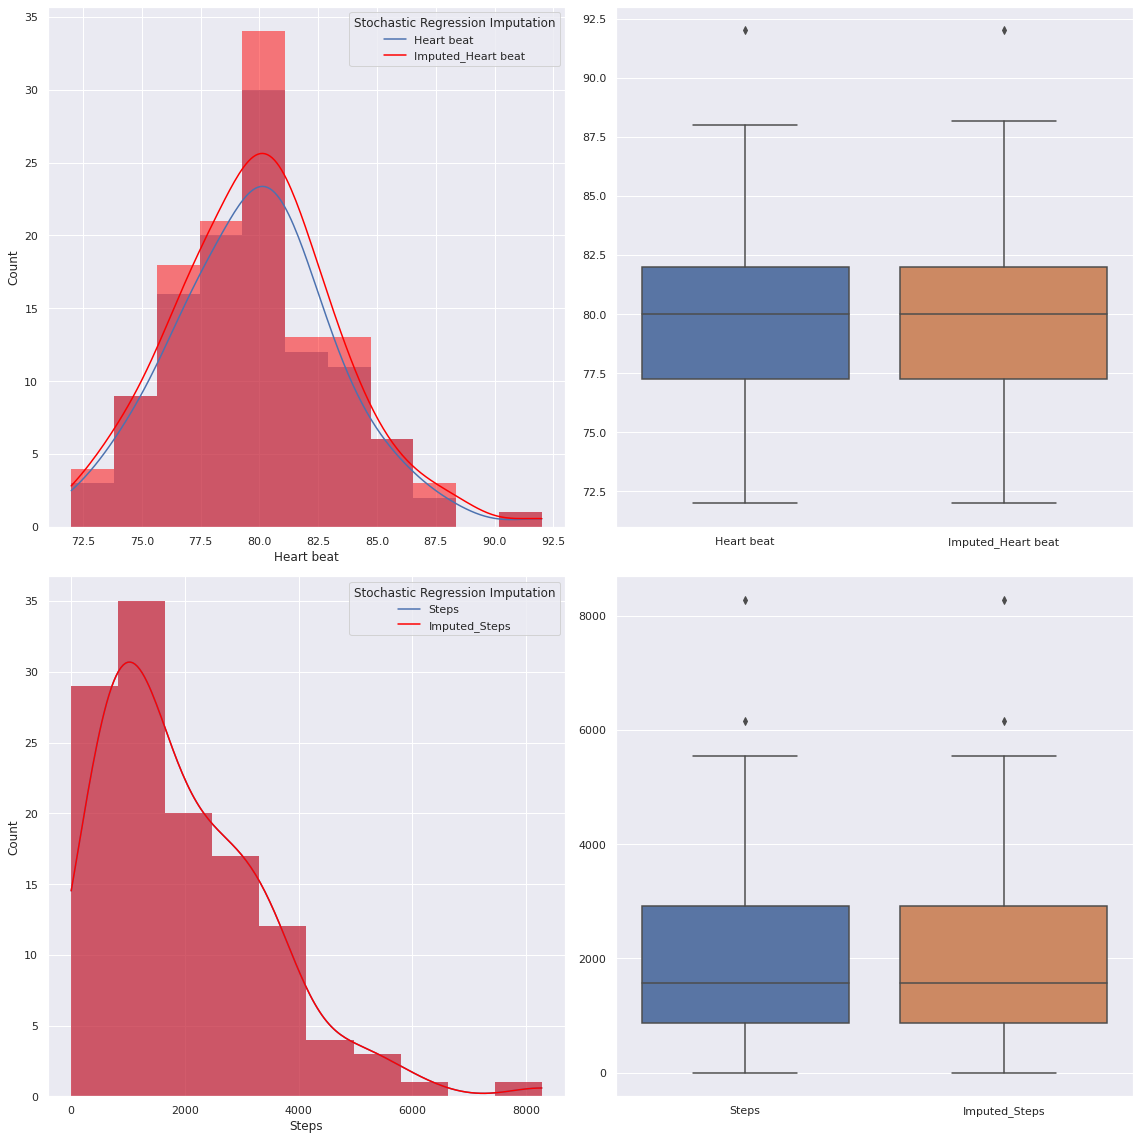

In [67]:
dfStochasticRegressionTest10 = stochasticRegressionImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                               .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                               [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [68]:
dfStochasticRegressionTest10 

3      78.228848
32     80.979325
45     82.565919
67     80.824119
79     76.855651
83     83.813349
88     75.858036
94     79.348833
101    79.371185
107    88.174955
118    73.331052
120    83.396604
Name: Heart beat, dtype: float64

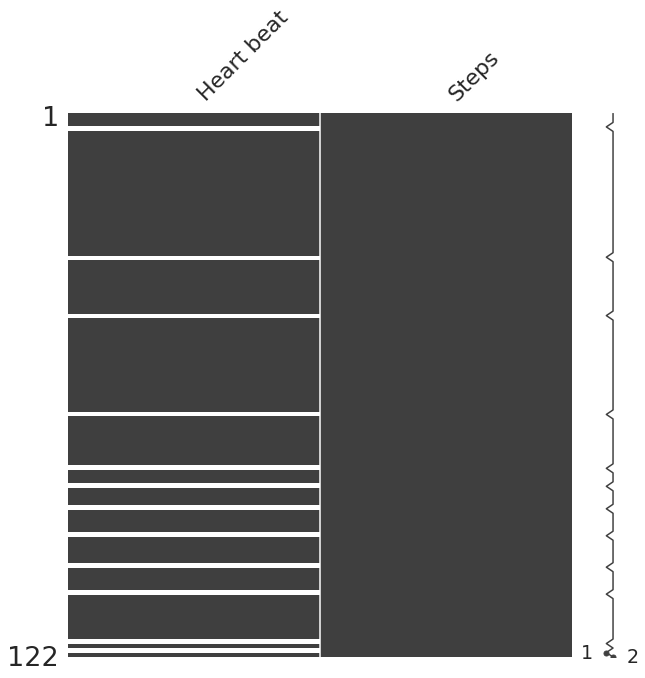

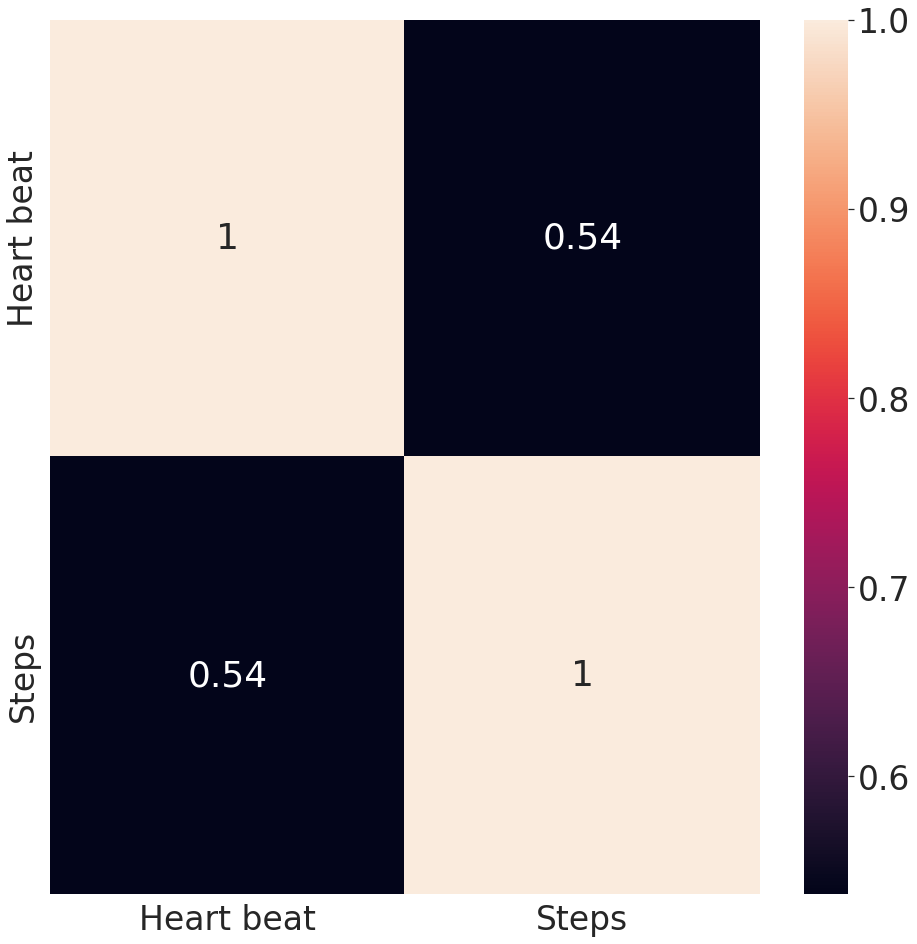

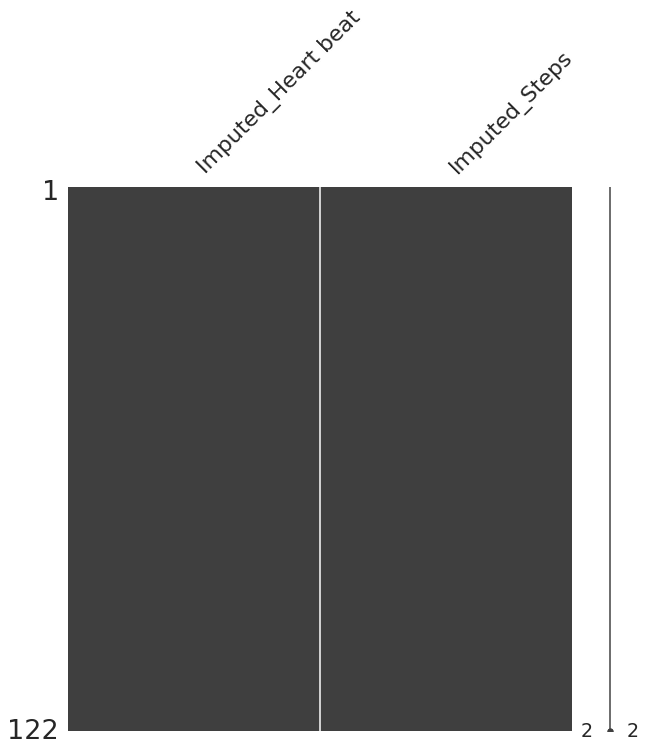

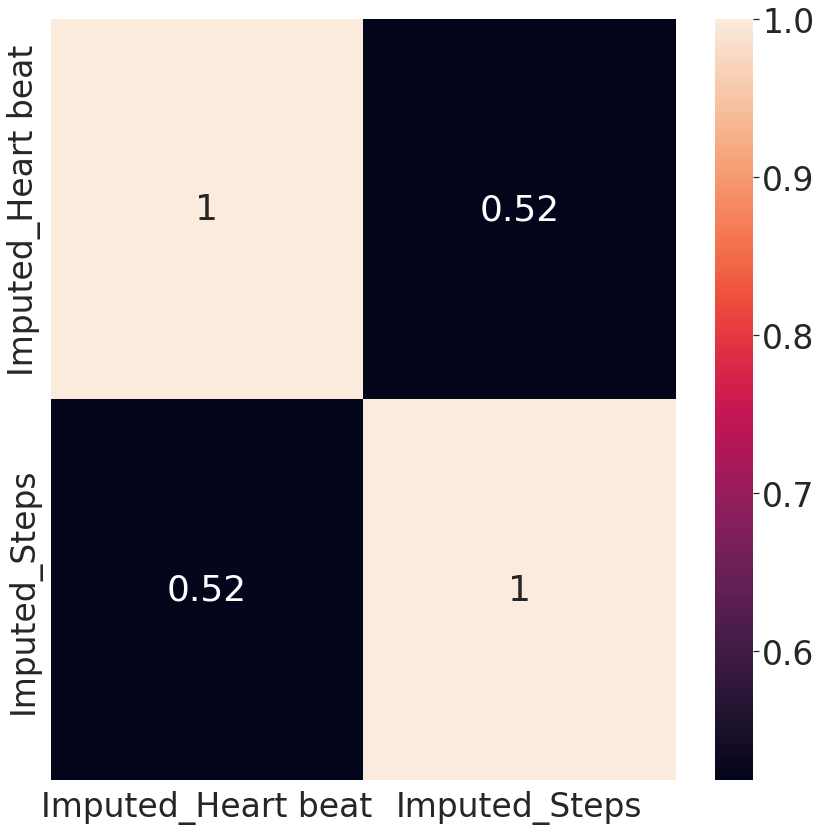

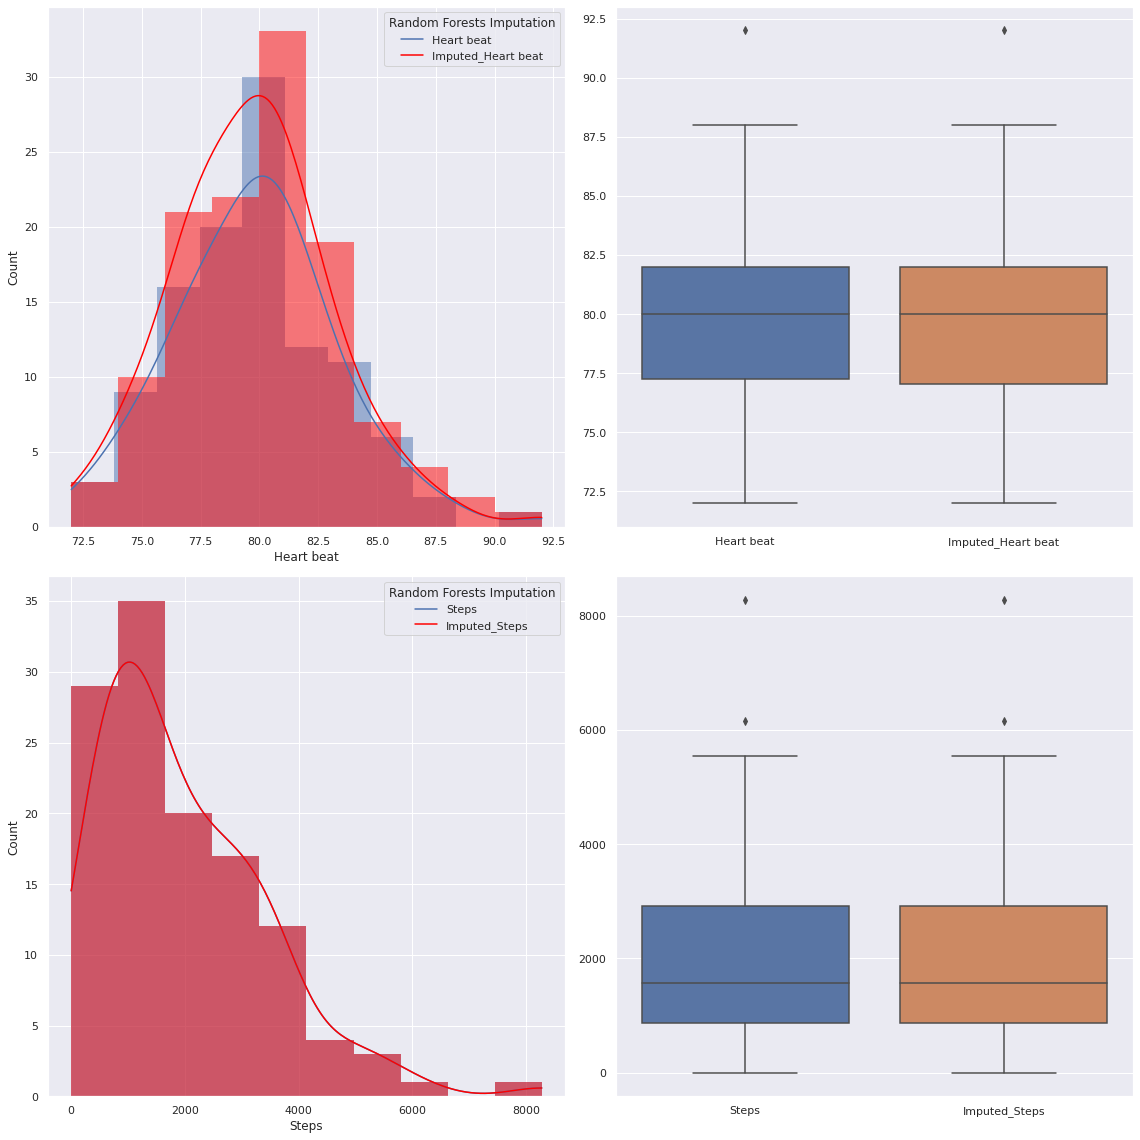

In [69]:
dfForestTest10 = randomForestImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTestTenPercent.toPandas().isnull().any(axis=1)]             

In [70]:
dfForestTest10

3      78.653846
32     80.738462
45     78.261538
67     77.869231
79     77.064615
83     75.000000
88     76.746154
94     80.007692
101    77.007692
107    80.661538
118    77.901026
120    83.115385
Name: Heart beat, dtype: float64

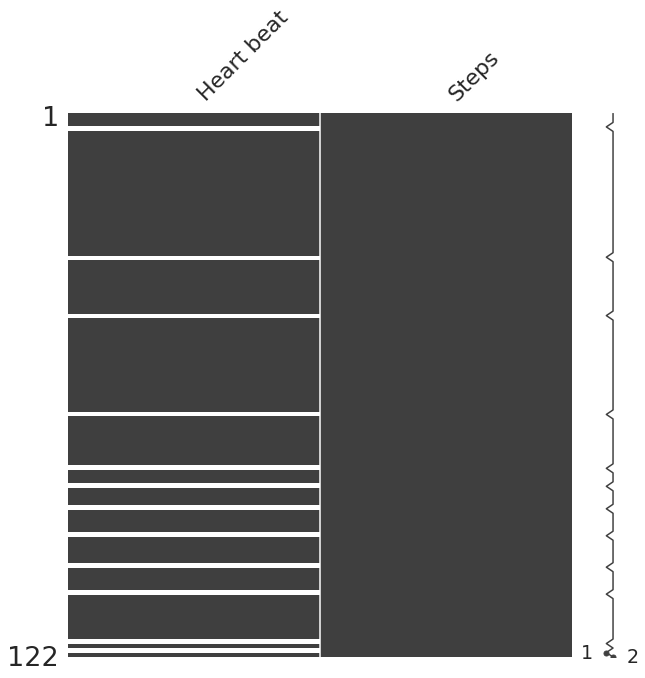

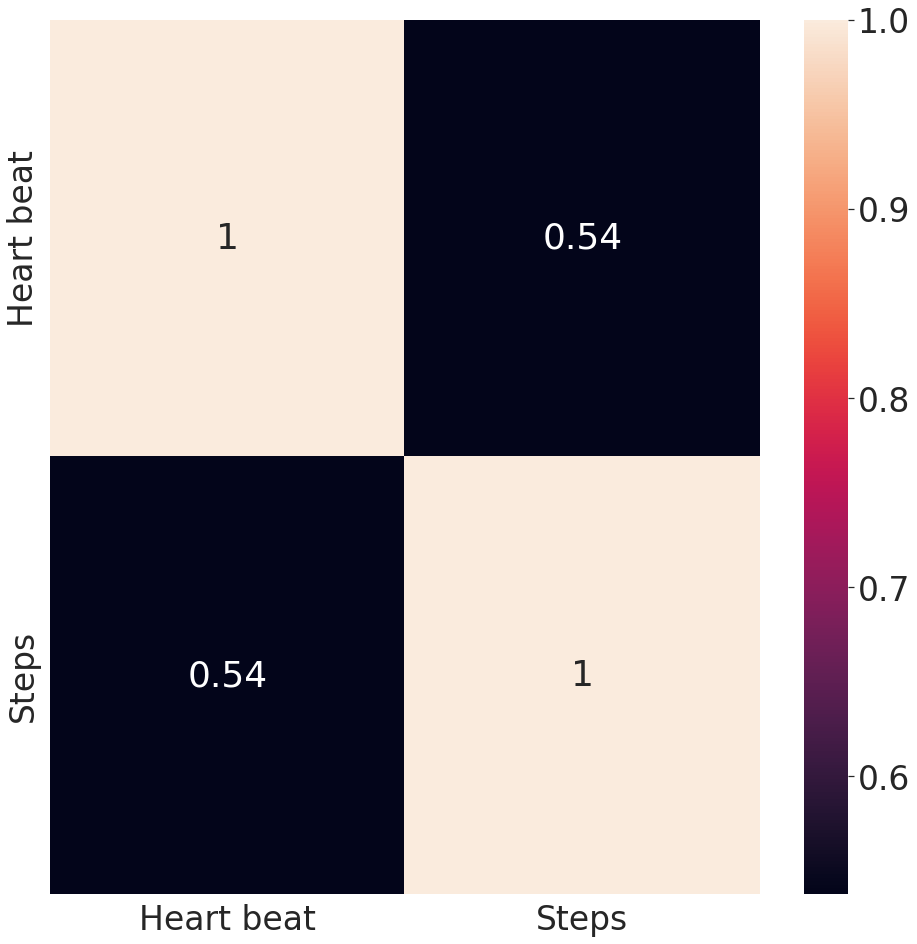

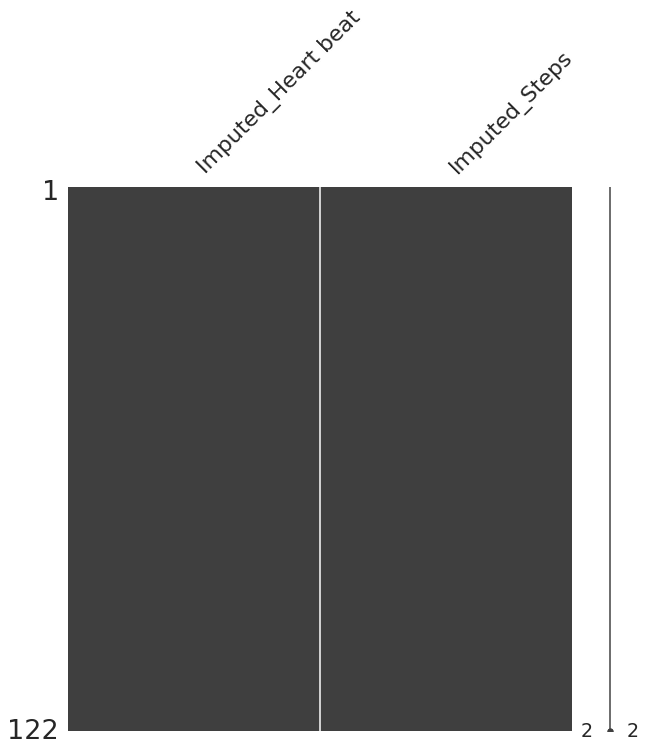

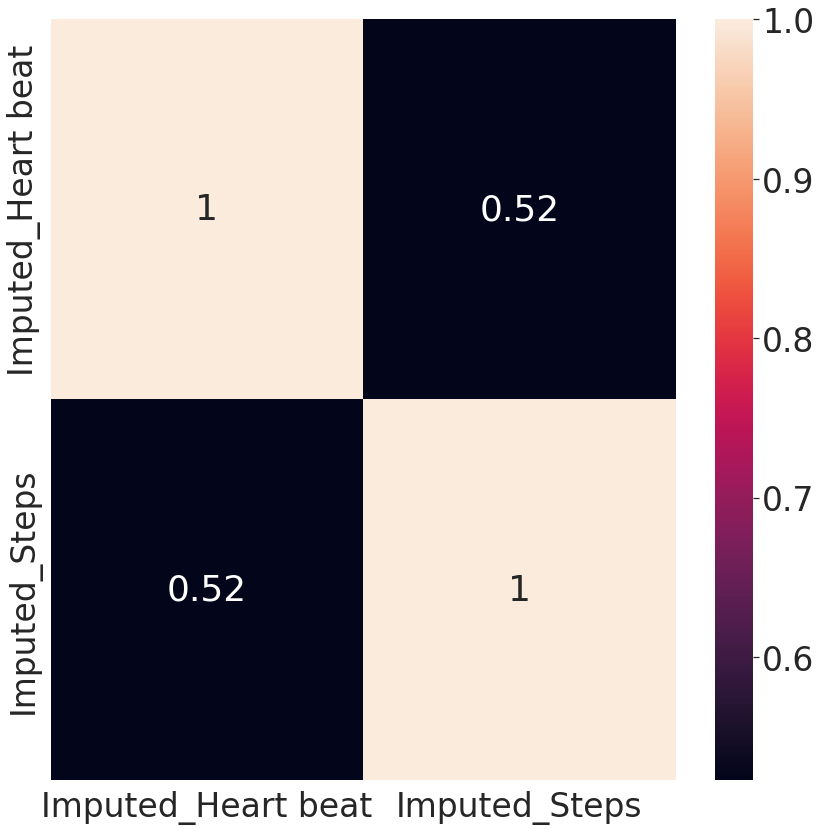

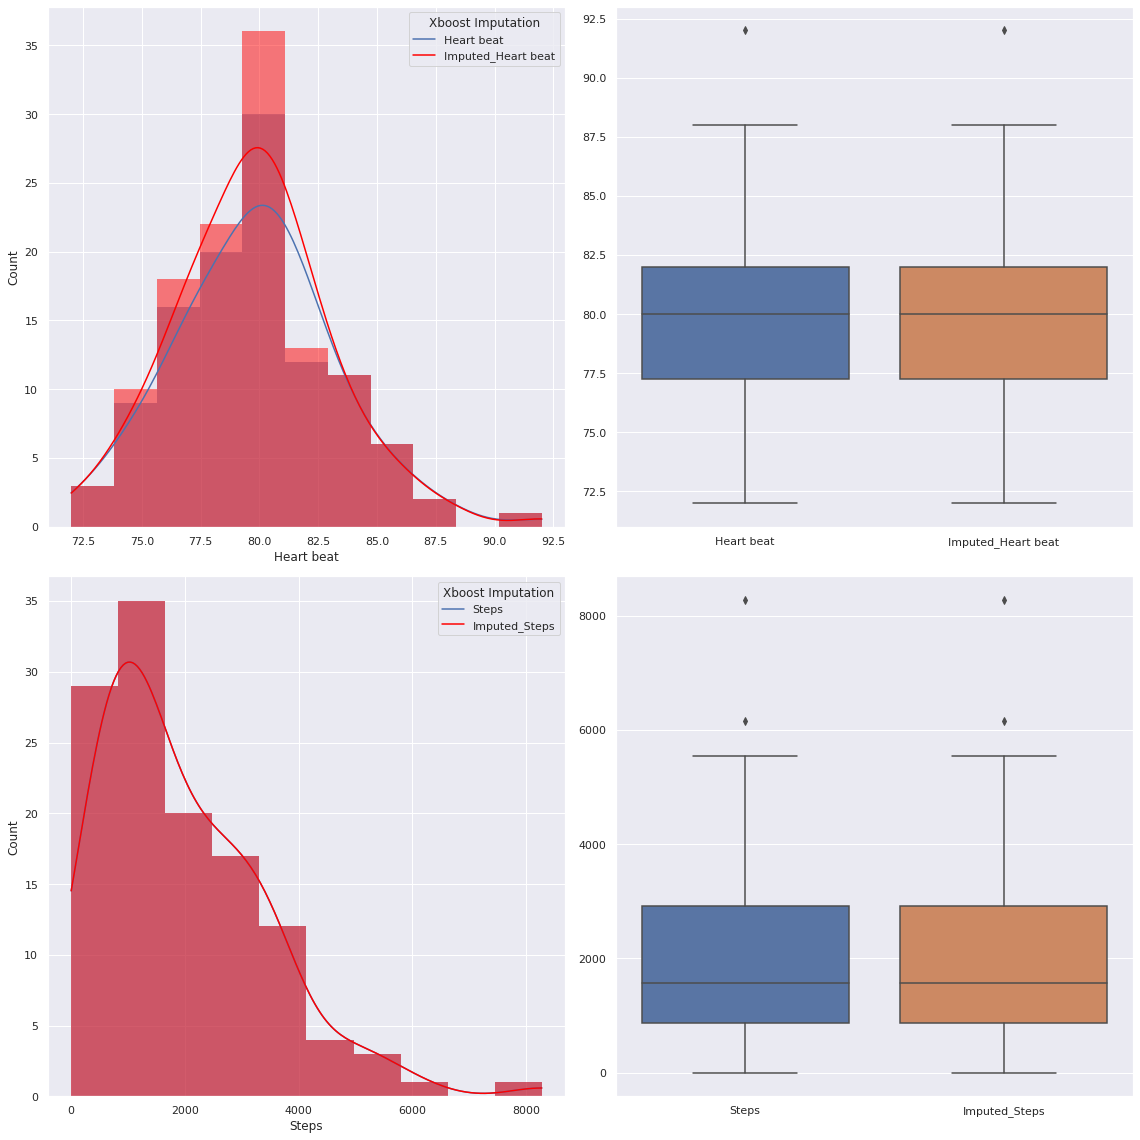

In [71]:
dfXgboostTest10 = xgboostImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [72]:
dfXgboostTest10

3      79.573868
32     80.406937
45     78.502113
67     79.313919
79     76.945435
83     75.455109
88     77.001564
94     79.656158
101    77.997299
107    81.872177
118    79.428291
120    79.925224
Name: Heart beat, dtype: float64

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


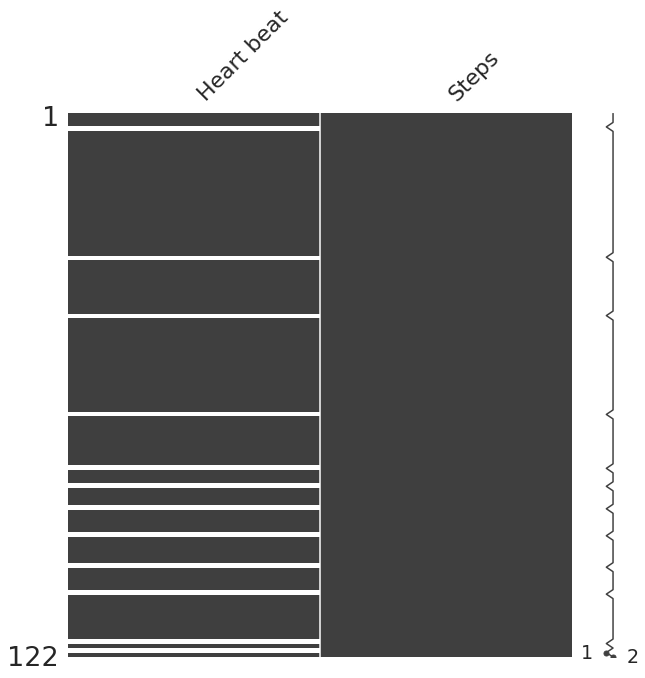

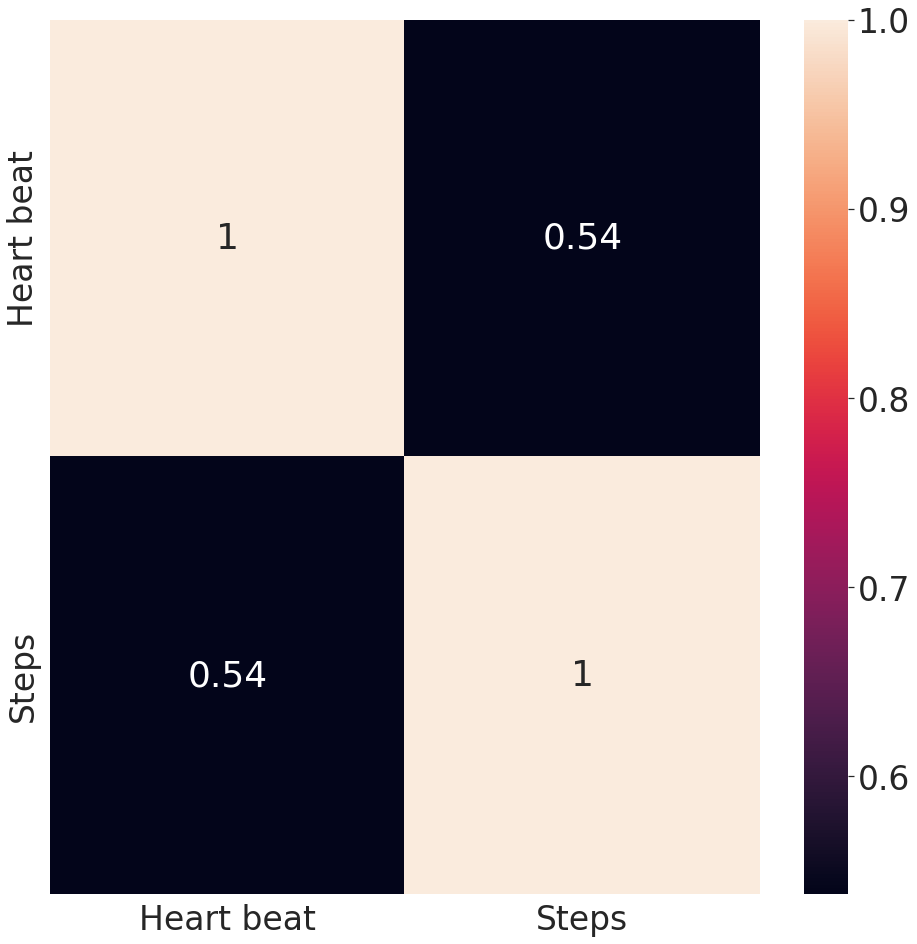

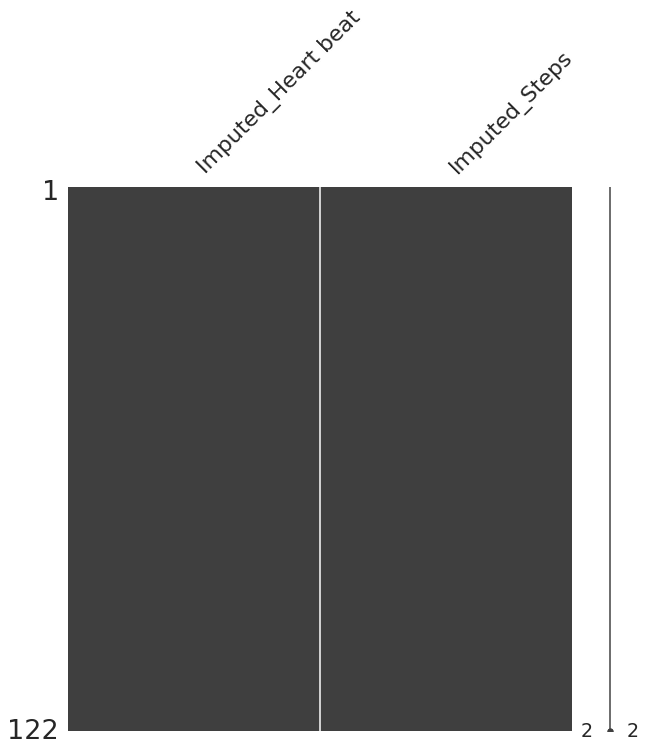

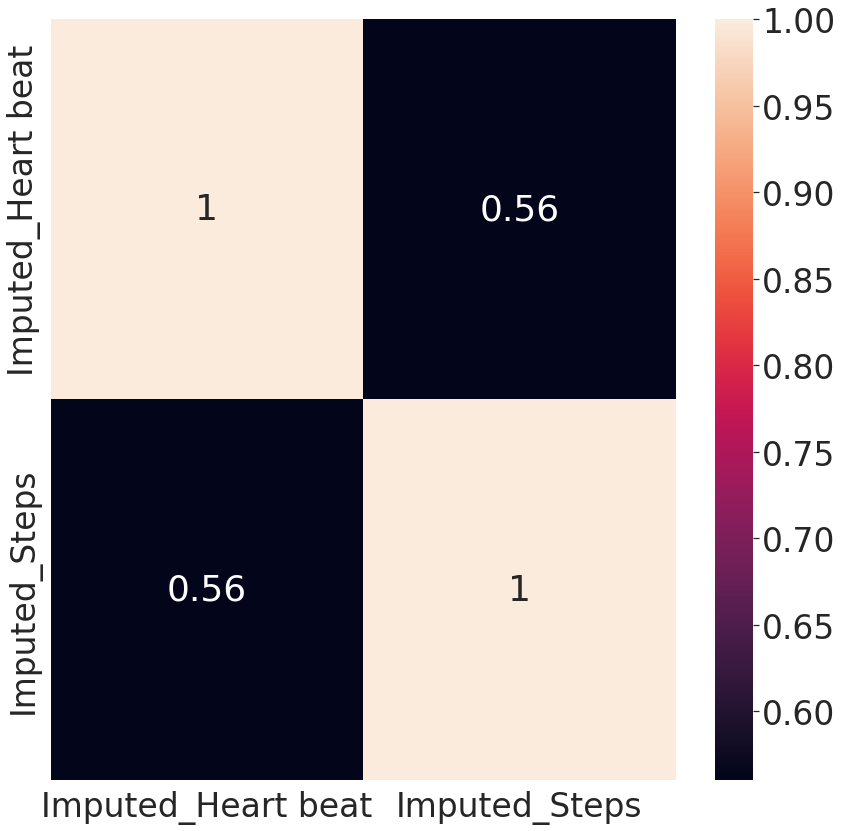

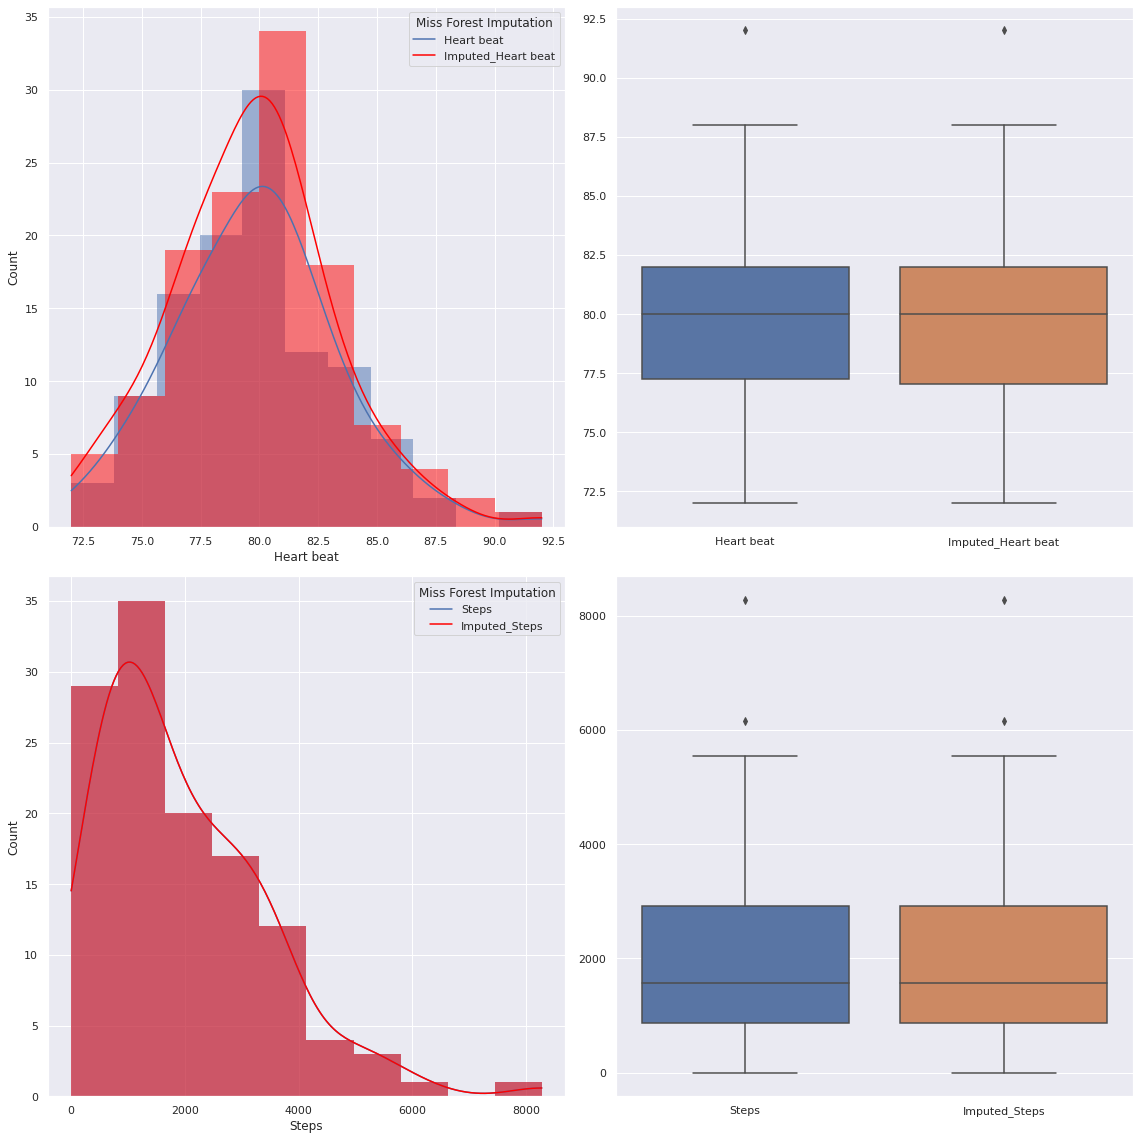

In [73]:
dfMiss10 = MissForestImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [74]:
dfMiss10

3      78.54
32     80.50
45     77.16
67     80.08
79     73.32
83     79.92
88     76.79
94     80.69
101    77.81
107    81.66
118    73.03
120    79.35
Name: Heart beat, dtype: float64

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 2.5085401721084253, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


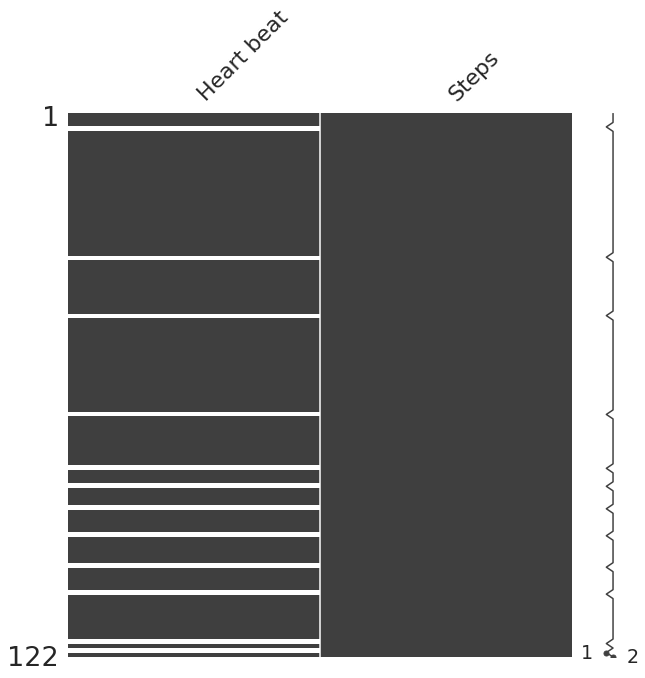

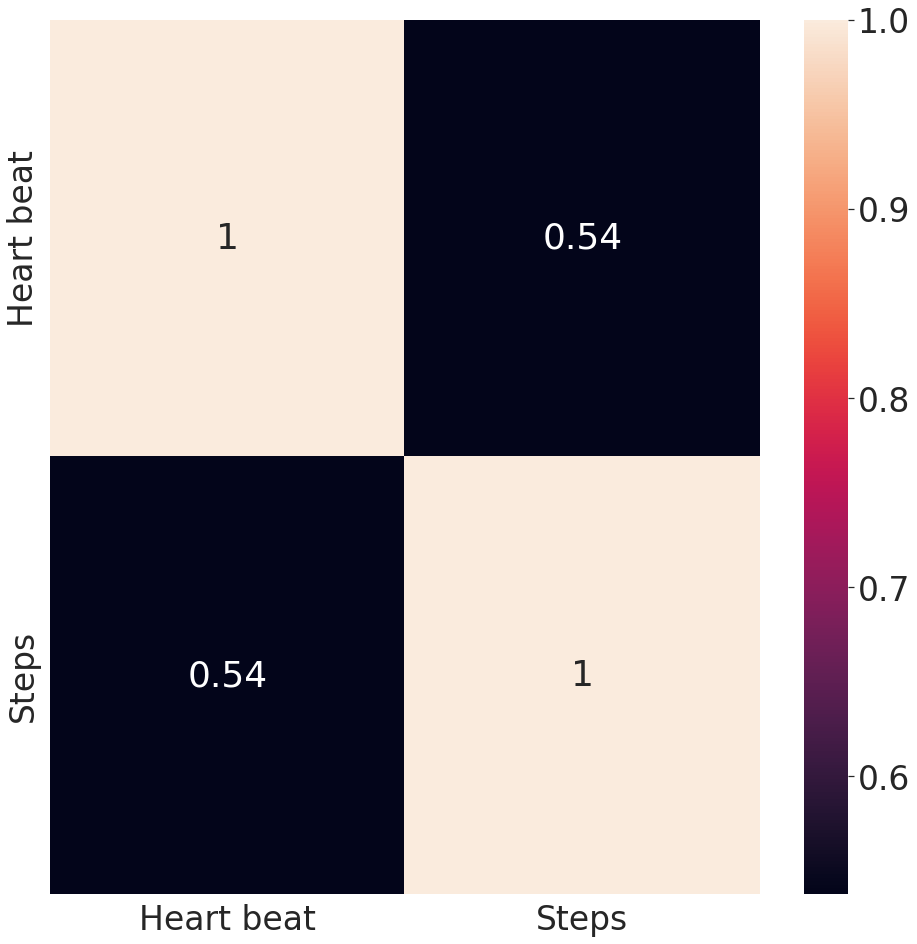

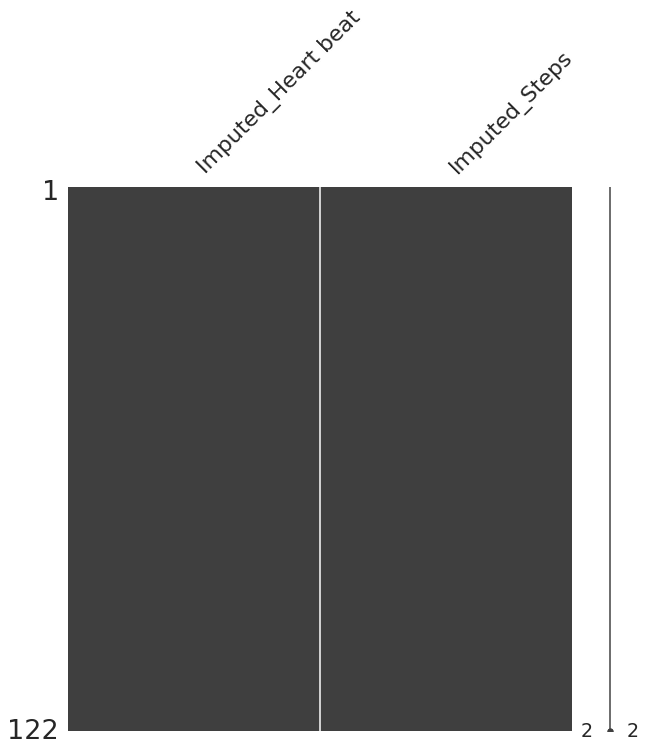

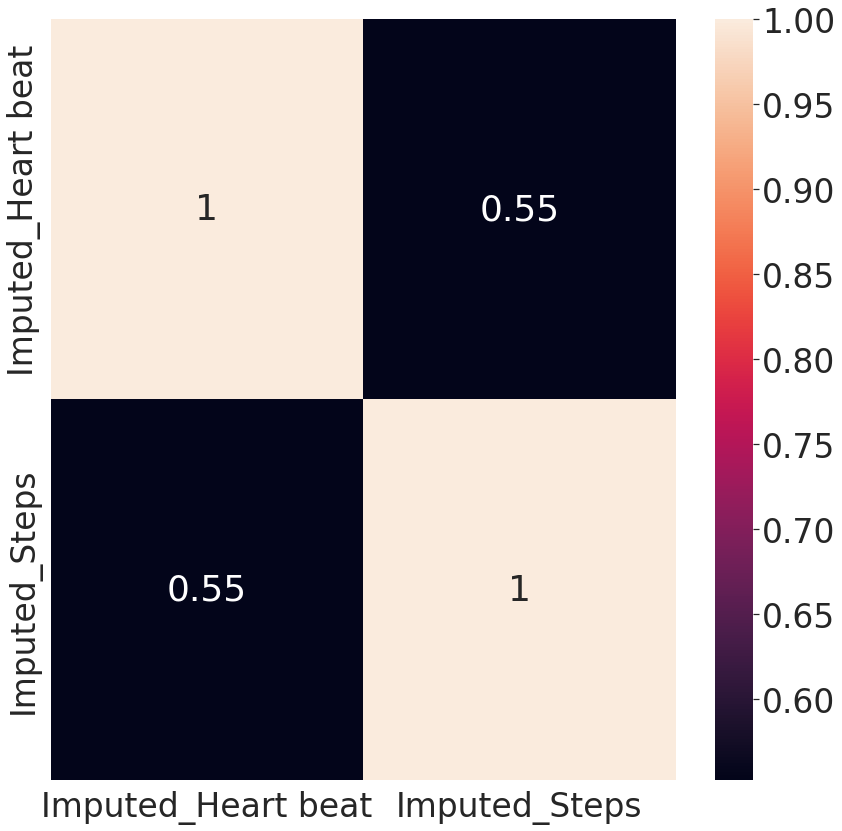

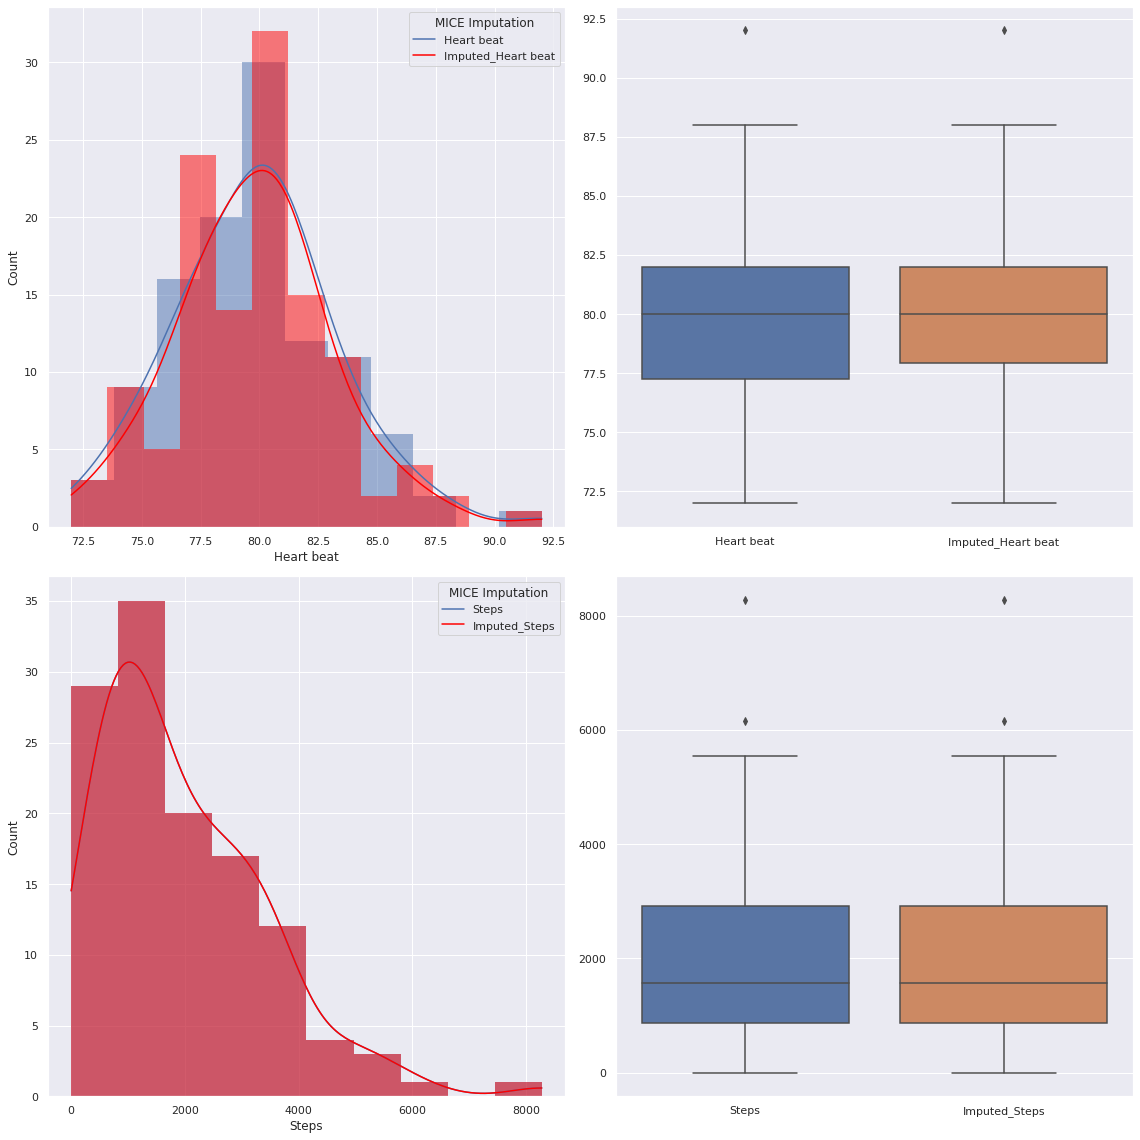

In [75]:
dfMICE10 = MICEImputation(dfTestTenPercent,5,True,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [76]:
dfMICE10

3      78.914599
32     81.212947
45     78.647320
67     81.263377
79     77.324793
83     81.798356
88     77.932055
94     81.336080
101    78.789785
107    80.886413
118    77.484908
120    79.057064
Name: Heart beat, dtype: float64

In [77]:
dforiginal10 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTestTenPercent.toPandas().isnull().any(axis=1)]

In [78]:
dforiginal10

3      75.0
32     78.0
45     85.0
67     78.0
79     76.0
83     82.0
88     78.0
94     76.0
101    77.0
107    79.0
118    73.0
120    78.0
Name: Heart beat, dtype: float64

In [79]:
from sklearn.metrics import mean_squared_error

In [80]:
dfRMSE10 = pd.DataFrame({
     'Percentage of missing data': ['10%','10%','10%','10%','10%','10%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest10,dforiginal10,squared=False),
               mean_squared_error(dfStochasticRegressionTest10,dforiginal10,squared=False),
               mean_squared_error(dfForestTest10,dforiginal10,squared=False),
               mean_squared_error(dfXgboostTest10,dforiginal10,squared=False),
               mean_squared_error(dfMICE10,dforiginal10,squared=False),
               mean_squared_error(dfMiss10,dforiginal10,squared=False)]
})

###RMSE 10%

In [81]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


In [82]:
absError10 = pd.DataFrame({
    'Original': dforiginal10,
    'RegressionIMP': dfRegressionTest10,
    'ABSErroRegr': np.abs(dforiginal10 - dfRegressionTest10),
    'StochasticIMP': dfStochasticRegressionTest10,
    'ABSErrorStoc': np.abs(dforiginal10 - dfStochasticRegressionTest10),
    'RandomForestIMP': dfForestTest10,
    'ABSErrorRanFor' : np.abs(dforiginal10 - dfForestTest10),
    'XgboostIMP': dfXgboostTest10,
    'ABSErrorXgb': np.abs(dforiginal10 - dfXgboostTest10),
    'MiceIMP': dfMICE10,
    'ABSErrorMice': np.abs(dforiginal10 - dfMICE10),
    'MissForestIMP': dfMiss10,
    'ABSErrorMissFor': np.abs(dforiginal10 - dfMiss10),
})

In [83]:
absError10

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
3,75.0,78.975342,3.975342,78.228848,3.228848,78.653846,3.653846,79.573868,4.573868,78.914599,3.914599,78.54,3.54
32,78.0,80.997669,2.997669,80.979325,2.979325,80.738462,2.738462,80.406937,2.406937,81.212947,3.212947,80.50,2.50
45,85.0,78.740162,6.259838,82.565919,2.434081,78.261538,6.738462,78.502113,6.497887,78.647320,6.352680,77.16,7.84
67,78.0,81.042043,3.042043,80.824119,2.824119,77.869231,0.130769,79.313919,1.313919,81.263377,3.263377,80.08,2.08
79,76.0,77.576465,1.576465,76.855651,0.855651,77.064615,1.064615,76.945435,0.945435,77.324793,1.324793,73.32,2.68
83,82.0,81.512773,0.487227,83.813349,1.813349,75.000000,7.000000,75.455109,6.544891,81.798356,0.201644,79.92,2.08
88,78.0,78.110797,0.110797,75.858036,2.141964,76.746154,1.253846,77.001564,0.998436,77.932055,0.067945,76.79,1.21
94,76.0,81.106015,5.106015,79.348833,3.348833,80.007692,4.007692,79.656158,3.656158,81.336080,5.336080,80.69,4.69
101,77.0,78.865518,1.865518,79.371185,2.371185,77.007692,0.007692,77.997299,0.997299,78.789785,1.789785,77.81,0.81
107,79.0,80.710350,1.710350,88.174955,9.174955,80.661538,1.661538,81.872177,2.872177,80.886413,1.886413,81.66,2.66


In [84]:
absError10=absError10.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal10 - dfRegressionTest10)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal10 - dfStochasticRegressionTest10)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal10 - dfForestTest10)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal10 - dfXgboostTest10)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal10 - dfMICE10)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal10 - dfMiss10))
}, ignore_index=True)

In [85]:
absError10=absError10.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal10 - dfRegressionTest10)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal10 - dfStochasticRegressionTest10)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal10 - dfForestTest10)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal10 - dfXgboostTest10)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal10 - dfMICE10)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal10 - dfMiss10))
}, ignore_index=True)

###Absolute errors 10%

In [86]:
absError10

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,75.0,78.975342,3.975342,78.228848,3.228848,78.653846,3.653846,79.573868,4.573868,78.914599,3.914599,78.54,3.5400,NaN
1,78.0,80.997669,2.997669,80.979325,2.979325,80.738462,2.738462,80.406937,2.406937,81.212947,3.212947,80.50,2.5000,NaN
2,85.0,78.740162,6.259838,82.565919,2.434081,78.261538,6.738462,78.502113,6.497887,78.647320,6.352680,77.16,7.8400,NaN
3,78.0,81.042043,3.042043,80.824119,2.824119,77.869231,0.130769,79.313919,1.313919,81.263377,3.263377,80.08,2.0800,NaN
4,76.0,77.576465,1.576465,76.855651,0.855651,77.064615,1.064615,76.945435,0.945435,77.324793,1.324793,73.32,2.6800,NaN
5,82.0,81.512773,0.487227,83.813349,1.813349,75.000000,7.000000,75.455109,6.544891,81.798356,0.201644,79.92,2.0800,NaN
6,78.0,78.110797,0.110797,75.858036,2.141964,76.746154,1.253846,77.001564,0.998436,77.932055,0.067945,76.79,1.2100,NaN
7,76.0,81.106015,5.106015,79.348833,3.348833,80.007692,4.007692,79.656158,3.656158,81.336080,5.336080,80.69,4.6900,NaN
8,77.0,78.865518,1.865518,79.371185,2.371185,77.007692,0.007692,77.997299,0.997299,78.789785,1.789785,77.81,0.8100,NaN
9,79.0,80.710350,1.710350,88.174955,9.174955,80.661538,1.661538,81.872177,2.872177,80.886413,1.886413,81.66,2.6600,NaN


##Testing with 20% of missing data

In [87]:
dfTest20Percent = fakeMissData('Heart beat', dfTest,5,20)

In [88]:
dfTest20Percent.show(150)

+----------+----------+----------+------------------+
|Patient_id|      date|Heart beat|             Steps|
+----------+----------+----------+------------------+
| 568140626|2021-11-15|      75.0|             533.0|
| 568140626|2021-11-16|      78.0|            2993.0|
| 568140626|2021-11-17|      80.0|            1331.9|
| 568140626|2021-11-18|       NaN|            1261.0|
| 568140626|2021-11-19|      79.0|1002.3333333333334|
| 568140626|2021-11-20|      75.0|1266.3333333333333|
| 568140626|2021-11-21|       NaN|             216.0|
| 568140626|2021-11-22|      81.0|            3372.5|
| 568140626|2021-11-23|      77.0| 867.2857142857143|
| 568140626|2021-11-24|      77.0| 846.3333333333334|
| 568140626|2021-11-25|      78.0|2152.3333333333335|
| 568140626|2021-11-26|      74.0|            2420.0|
| 568140626|2021-11-27|      82.0|3741.3333333333335|
| 568140626|2021-11-28|      81.0|            1687.0|
| 568140626|2021-11-29|       NaN|            2730.5|
| 568140626|2021-11-30|     

In [89]:
dfRegressionTest20 = regressionImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]

In [90]:
dfRegressionTest20

3      78.926092
6      77.811156
14     80.493937
20     80.835887
31     82.625119
32     80.871095
45     78.699904
47     79.344113
48     79.230432
59     79.963143
60     77.868770
67     80.913772
69     78.188848
79     77.580701
83     81.366504
88     78.094603
94     80.975298
99     79.052523
101    78.820467
107    80.594762
110    81.147429
113    78.214454
115    79.545709
119    80.185916
Name: Heart beat, dtype: float64

In [91]:
dfStochasticRegressionTest20 = stochasticRegressionImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]

In [92]:
dfStochasticRegressionTest20

3      78.164785
6      75.065315
14     75.466350
20     77.874494
31     80.717800
32     80.852387
45     82.601576
47     80.837301
48     78.214712
59     80.340054
60     76.552964
67     80.691524
69     80.572699
79     76.845584
83     83.712730
88     75.797140
94     79.183248
99     80.563972
101    79.336168
107    88.207489
110    81.286211
113    77.364547
115    76.020579
119    80.134742
Name: Heart beat, dtype: float64

In [93]:
dfForestTest20 = randomForestImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]            

In [94]:
dfForestTest20

3      80.430769
6      76.653846
14     80.123077
20     81.323077
31     79.723077
32     76.600000
45     77.653846
47     84.038462
48     78.992308
59     78.853846
60     79.915385
67     79.576923
69     78.623077
79     75.190385
83     78.738462
88     80.946154
94     78.853846
99     81.476923
101    73.961538
107    80.938462
110    84.246154
113    79.915385
115    76.776923
119    79.446154
Name: Heart beat, dtype: float64

In [95]:
dfXgboostTest20 = xgboostImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]

In [96]:
dfXgboostTest20

3      81.133514
6      76.241768
14     81.299568
20     80.957672
31     80.093506
32     78.614723
45     78.416862
47     80.488510
48     79.125038
59     79.441063
60     79.165871
67     79.496727
69     78.400185
79     75.333153
83     80.064697
88     80.764786
94     79.496727
99     80.068893
101    76.240433
107    81.299568
110    83.063232
113    79.363510
115    80.112732
119    79.558456
Name: Heart beat, dtype: float64

In [97]:
dfMICE20 = MICEImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 3.416217051390049, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.00
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


In [98]:
dfMICE20

3      78.814521
6      77.516703
14     80.639540
20     81.037579
31     83.120299
32     81.078563
45     78.551232
47     79.301110
48     79.168782
59     80.021679
60     77.583767
67     81.128240
69     77.956347
79     77.248445
83     81.655233
88     77.846643
94     81.199858
99     78.961690
101    78.691570
107    80.756903
110    81.400223
113    77.986153
115    79.535773
119    80.280994
Name: Heart beat, dtype: float64

In [99]:
dfMiss20 = MissForestImputation(dfTest20Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest20Percent.toPandas().isnull().any(axis=1)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [100]:
dfMiss20  

3      78.38
6      73.48
14     81.24
20     80.43
31     82.62
32     79.99
45     77.12
47     80.45
48     81.20
59     81.60
60     76.82
67     80.07
69     77.44
79     73.00
83     80.08
88     76.69
94     80.17
99     78.85
101    77.59
107    86.54
110    82.11
113    80.66
115    80.56
119    79.23
Name: Heart beat, dtype: float64

In [101]:
dforiginal20 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTest20Percent.toPandas().isnull().any(axis=1)]

In [102]:
dforiginal20

3      75.000000
6      74.000000
14     79.000000
20     82.000000
31     85.000000
32     78.000000
45     85.000000
47     81.000000
48     78.000000
59     86.000000
60     79.000000
67     78.000000
69     75.000000
79     76.000000
83     82.000000
88     78.000000
94     76.000000
99     80.000000
101    77.000000
107    79.000000
110    80.000000
113    77.000000
115    83.666667
119    82.000000
Name: Heart beat, dtype: float64

In [232]:
dfRMSE20 = pd.DataFrame({
     'Percentage of missing data': ['20%','20%','20%','20%','20%','20%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest20,dforiginal20,squared=False),
               mean_squared_error(dfStochasticRegressionTest20,dforiginal20,squared=False),
               mean_squared_error(dfForestTest20,dforiginal20,squared=False),
               mean_squared_error(dfXgboostTest20,dforiginal20,squared=False),
               mean_squared_error(dfMICE20,dforiginal20,squared=False),
               mean_squared_error(dfMiss20,dforiginal20,squared=False)]
})

In [104]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


###RMSE 20%

In [105]:
dfRMSE20

,Percentage of missing data,imputation method,RMSE
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551
4,20%,MICE Imputation,2.918132
5,20%,Miss Forest Imputation,3.299464


In [106]:
absError20 = pd.DataFrame({
    'Original': dforiginal20,
    'RegressionIMP': dfRegressionTest20,
    'ABSErroRegr': np.abs(dforiginal20 - dfRegressionTest20),
    'StochasticIMP': dfStochasticRegressionTest20,
    'ABSErrorStoc': np.abs(dforiginal20 - dfStochasticRegressionTest20),
    'RandomForestIMP': dfForestTest20,
    'ABSErrorRanFor' : np.abs(dforiginal20 - dfForestTest20),
    'XgboostIMP': dfXgboostTest20,
    'ABSErrorXgb': np.abs(dforiginal20 - dfXgboostTest20),
    'MiceIMP': dfMICE20,
    'ABSErrorMice': np.abs(dforiginal20 - dfMICE20),
    'MissForestIMP': dfMiss20,
    'ABSErrorMissFor': np.abs(dforiginal20 - dfMiss20),
})

In [107]:
absError20

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
3,75.000000,78.926092,3.926092,78.164785,3.164785,80.430769,5.430769,81.133514,6.133514,78.814521,3.814521,78.38,3.380000
6,74.000000,77.811156,3.811156,75.065315,1.065315,76.653846,2.653846,76.241768,2.241768,77.516703,3.516703,73.48,0.520000
14,79.000000,80.493937,1.493937,75.466350,3.533650,80.123077,1.123077,81.299568,2.299568,80.639540,1.639540,81.24,2.240000
20,82.000000,80.835887,1.164113,77.874494,4.125506,81.323077,0.676923,80.957672,1.042328,81.037579,0.962421,80.43,1.570000
31,85.000000,82.625119,2.374881,80.717800,4.282200,79.723077,5.276923,80.093506,4.906494,83.120299,1.879701,82.62,2.380000
32,78.000000,80.871095,2.871095,80.852387,2.852387,76.600000,1.400000,78.614723,0.614723,81.078563,3.078563,79.99,1.990000
45,85.000000,78.699904,6.300096,82.601576,2.398424,77.653846,7.346154,78.416862,6.583138,78.551232,6.448768,77.12,7.880000
47,81.000000,79.344113,1.655887,80.837301,0.162699,84.038462,3.038462,80.488510,0.511490,79.301110,1.698890,80.45,0.550000
48,78.000000,79.230432,1.230432,78.214712,0.214712,78.992308,0.992308,79.125038,1.125038,79.168782,1.168782,81.20,3.200000
59,86.000000,79.963143,6.036857,80.340054,5.659946,78.853846,7.146154,79.441063,6.558937,80.021679,5.978321,81.60,4.400000


In [108]:
absError20=absError20.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP': np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal20 - dfRegressionTest20)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal20 - dfStochasticRegressionTest20)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal20 - dfForestTest20)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal20 - dfXgboostTest20)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal20 - dfMICE20)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal20 - dfMiss20))
}, ignore_index=True)

In [109]:
absError20=absError20.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal20 - dfRegressionTest20)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal20 - dfStochasticRegressionTest20)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal20 - dfForestTest20)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal20 - dfXgboostTest20)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal20 - dfMICE20)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal20 - dfMiss20))
}, ignore_index=True)

### Absolute errors 20%

In [110]:
absError20

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,75.000000,78.926092,3.926092,78.164785,3.164785,80.430769,5.430769,81.133514,6.133514,78.814521,3.814521,78.38,3.380000,NaN
1,74.000000,77.811156,3.811156,75.065315,1.065315,76.653846,2.653846,76.241768,2.241768,77.516703,3.516703,73.48,0.520000,NaN
2,79.000000,80.493937,1.493937,75.466350,3.533650,80.123077,1.123077,81.299568,2.299568,80.639540,1.639540,81.24,2.240000,NaN
3,82.000000,80.835887,1.164113,77.874494,4.125506,81.323077,0.676923,80.957672,1.042328,81.037579,0.962421,80.43,1.570000,NaN
4,85.000000,82.625119,2.374881,80.717800,4.282200,79.723077,5.276923,80.093506,4.906494,83.120299,1.879701,82.62,2.380000,NaN
5,78.000000,80.871095,2.871095,80.852387,2.852387,76.600000,1.400000,78.614723,0.614723,81.078563,3.078563,79.99,1.990000,NaN
6,85.000000,78.699904,6.300096,82.601576,2.398424,77.653846,7.346154,78.416862,6.583138,78.551232,6.448768,77.12,7.880000,NaN
7,81.000000,79.344113,1.655887,80.837301,0.162699,84.038462,3.038462,80.488510,0.511490,79.301110,1.698890,80.45,0.550000,NaN
8,78.000000,79.230432,1.230432,78.214712,0.214712,78.992308,0.992308,79.125038,1.125038,79.168782,1.168782,81.20,3.200000,NaN
9,86.000000,79.963143,6.036857,80.340054,5.659946,78.853846,7.146154,79.441063,6.558937,80.021679,5.978321,81.60,4.400000,NaN


##Testing with 30% of missing data

In [111]:
dfTest30Percent = fakeMissData('Heart beat', dfTest,5,30)

In [112]:
dfTest30Percent.show(150)

+----------+----------+----------+------------------+
|Patient_id|      date|Heart beat|             Steps|
+----------+----------+----------+------------------+
| 568140626|2021-11-15|      75.0|             533.0|
| 568140626|2021-11-16|       NaN|            2993.0|
| 568140626|2021-11-17|      80.0|            1331.9|
| 568140626|2021-11-18|       NaN|            1261.0|
| 568140626|2021-11-19|      79.0|1002.3333333333334|
| 568140626|2021-11-20|      75.0|1266.3333333333333|
| 568140626|2021-11-21|       NaN|             216.0|
| 568140626|2021-11-22|      81.0|            3372.5|
| 568140626|2021-11-23|      77.0| 867.2857142857143|
| 568140626|2021-11-24|       NaN| 846.3333333333334|
| 568140626|2021-11-25|      78.0|2152.3333333333335|
| 568140626|2021-11-26|      74.0|            2420.0|
| 568140626|2021-11-27|      82.0|3741.3333333333335|
| 568140626|2021-11-28|       NaN|            1687.0|
| 568140626|2021-11-29|       NaN|            2730.5|
| 568140626|2021-11-30|     

In [113]:
dfRegressionTest30 = regressionImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]

In [114]:
dfRegressionTest30

1      80.596434
3      79.200895
6      78.358899
9      78.866783
13     79.544140
14     80.384927
20     80.643166
23     80.544061
27     80.262052
31     81.994389
32     80.669756
35     80.220384
45     79.030079
47     79.516583
48     79.430732
49     79.376143
52     81.196709
59     79.984073
60     78.402409
67     80.701985
69     78.644130
73     80.118631
79     78.184860
83     81.043887
88     78.572957
93     80.759193
94     80.748450
99     79.296375
100    79.484515
101    79.121127
104    79.250045
107    80.461070
110    80.878442
113    78.663468
115    79.668828
119    80.152311
Name: Heart beat, dtype: float64

In [115]:
dfStochasticRegressionTest30 = stochasticRegressionImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]

In [116]:
dfStochasticRegressionTest30

1      79.651199
3      78.480715
6      75.761390
9      77.924405
13     81.268146
14     75.628935
20     77.841751
23     79.337034
27     79.224140
31     80.190106
32     80.652058
35     80.932353
45     82.720979
47     80.929108
48     78.469882
49     79.088707
52     77.452072
59     80.340623
60     77.157683
67     80.491743
69     80.899204
73     78.898681
79     77.489455
83     83.263368
88     76.399605
93     78.779916
94     79.053208
99     80.726175
100    81.748320
101    79.608970
104    80.673680
107    87.662550
110    81.009728
113    77.859474
115    76.334129
119    80.103901
Name: Heart beat, dtype: float64

In [117]:
dfForestTest30 = randomForestImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]              

In [118]:
dfForestTest30

1      81.600000
3      80.900000
6      83.646154
9      78.792308
13     81.946154
14     79.800000
20     81.076923
23     82.400000
27     81.192308
31     77.292308
32     82.938462
35     80.600000
45     75.830769
47     81.684615
48     80.438462
49     77.738462
52     80.646154
59     78.853846
60     83.653846
67     81.546154
69     79.900000
73     78.753846
79     78.008077
83     78.738462
88     79.146154
93     80.607692
94     80.607692
99     77.646154
100    83.015385
101    80.815385
104    77.892308
107    79.523077
110    77.946154
113    81.546154
115    80.884615
119    82.492308
Name: Heart beat, dtype: float64

In [119]:
dfXgboostTest30 = xgboostImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]

In [120]:
dfXgboostTest30

1      81.146088
3      81.325012
6      84.940353
9      78.318924
13     80.775276
14     80.842728
20     81.146088
23     81.146088
27     80.842728
31     76.149681
32     81.146088
35     80.842728
45     77.620682
47     81.087097
48     79.971748
49     78.786041
52     80.714714
59     80.463295
60     85.185577
67     81.146088
69     79.868919
73     79.987122
79     77.718636
83     79.780243
88     80.122871
93     81.146088
94     81.146088
99     78.786041
100    81.379593
101    78.997238
104    78.090294
107    80.842728
110    78.110191
113    79.868919
115    80.775276
119    81.159210
Name: Heart beat, dtype: float64

In [121]:
dfMICE30 = MICEImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 3.3944195920120848, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.00
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


In [122]:
dfMICE30

1      80.750432
3      78.644975
6      77.374650
9      78.140897
13     79.162829
14     80.431331
20     80.820938
23     80.671416
27     80.245949
31     82.859536
32     80.861053
35     80.183084
45     78.387263
47     79.121255
48     78.991731
49     78.909372
52     81.656070
59     79.826559
60     77.440293
67     80.909678
69     77.804980
73     80.029568
79     77.112075
83     81.425507
88     77.697600
93     80.995987
94     80.979779
99     78.789026
100    79.072873
101    78.524628
104    78.719127
107    80.546207
110    81.175899
113    77.834155
115    79.350947
119    80.080381
Name: Heart beat, dtype: float64

In [123]:
dfMiss30 = MissForestImputation(dfTest30Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest30Percent.toPandas().isnull().any(axis=1)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [124]:
dfMiss30

1      81.42
3      77.80
6      73.53
9      77.07
13     81.15
14     81.26
20     80.52
23     83.88
27     80.48
31     82.62
32     80.48
35     82.28
45     77.44
47     80.22
48     81.30
49     77.77
52     81.86
59     81.70
60     77.01
67     81.28
69     77.66
73     78.41
79     73.12
83     79.92
88     77.02
93     83.31
94     83.28
99     78.79
100    79.33
101    77.83
104    79.45
107    83.83
110    81.74
113    80.78
115    80.69
119    79.16
Name: Heart beat, dtype: float64

In [125]:
dforiginal30 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTest30Percent.toPandas().isnull().any(axis=1)]

In [126]:
dforiginal30

1      78.000000
3      75.000000
6      74.000000
9      77.000000
13     81.000000
14     79.000000
20     82.000000
23     92.000000
27     82.000000
31     85.000000
32     78.000000
35     88.000000
45     85.000000
47     81.000000
48     78.000000
49     80.000000
52     80.000000
59     86.000000
60     79.000000
67     78.000000
69     75.000000
73     81.000000
79     76.000000
83     82.000000
88     78.000000
93     78.000000
94     76.000000
99     80.000000
100    79.000000
101    77.000000
104    81.000000
107    79.000000
110    80.000000
113    77.000000
115    83.666667
119    82.000000
Name: Heart beat, dtype: float64

In [127]:
dfRMSE30 = pd.DataFrame({
     'Percentage of missing data': ['30%','30%','30%','30%','30%','30%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest30,dforiginal30,squared=False),
               mean_squared_error(dfStochasticRegressionTest30,dforiginal30,squared=False),
               mean_squared_error(dfForestTest30,dforiginal30,squared=False),
               mean_squared_error(dfXgboostTest30,dforiginal30,squared=False),
               mean_squared_error(dfMICE30,dforiginal30,squared=False),
               mean_squared_error(dfMiss30,dforiginal30,squared=False)]
})

In [128]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


In [129]:
dfRMSE20

,Percentage of missing data,imputation method,RMSE
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551
4,20%,MICE Imputation,2.918132
5,20%,Miss Forest Imputation,3.299464


### RMSE 30%

In [130]:
dfRMSE30

,Percentage of missing data,imputation method,RMSE
0,30%,Linear Regression imputation,3.467501
1,30%,Stochastic Regression Imputation,3.925526
2,30%,Random Forests Imputation,4.444722
3,30%,xgboostImputation,4.379923
4,30%,MICE Imputation,3.443366
5,30%,Miss Forest Imputation,3.419505


In [131]:
absError30 = pd.DataFrame({
    'Original': dforiginal30,
    'RegressionIMP': dfRegressionTest30,
    'ABSErroRegr': np.abs(dforiginal30 - dfRegressionTest30),
    'StochasticIMP': dfStochasticRegressionTest30,
    'ABSErrorStoc': np.abs(dforiginal30 - dfStochasticRegressionTest30),
    'RandomForestIMP': dfForestTest30,
    'ABSErrorRanFor' : np.abs(dforiginal30 - dfForestTest30),
    'XgboostIMP': dfXgboostTest30,
    'ABSErrorXgb': np.abs(dforiginal30 - dfXgboostTest30),
    'MiceIMP': dfMICE30,
    'ABSErrorMice': np.abs(dforiginal30 - dfMICE30),
    'MissForestIMP': dfMiss30,
    'ABSErrorMissFor': np.abs(dforiginal30 - dfMiss30),
})

In [132]:
absError30

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
1,78.000000,80.596434,2.596434,79.651199,1.651199,81.600000,3.600000,81.146088,3.146088,80.750432,2.750432,81.42,3.420000
3,75.000000,79.200895,4.200895,78.480715,3.480715,80.900000,5.900000,81.325012,6.325012,78.644975,3.644975,77.80,2.800000
6,74.000000,78.358899,4.358899,75.761390,1.761390,83.646154,9.646154,84.940353,10.940353,77.374650,3.374650,73.53,0.470000
9,77.000000,78.866783,1.866783,77.924405,0.924405,78.792308,1.792308,78.318924,1.318924,78.140897,1.140897,77.07,0.070000
13,81.000000,79.544140,1.455860,81.268146,0.268146,81.946154,0.946154,80.775276,0.224724,79.162829,1.837171,81.15,0.150000
14,79.000000,80.384927,1.384927,75.628935,3.371065,79.800000,0.800000,80.842728,1.842728,80.431331,1.431331,81.26,2.260000
20,82.000000,80.643166,1.356834,77.841751,4.158249,81.076923,0.923077,81.146088,0.853912,80.820938,1.179062,80.52,1.480000
23,92.000000,80.544061,11.455939,79.337034,12.662966,82.400000,9.600000,81.146088,10.853912,80.671416,11.328584,83.88,8.120000
27,82.000000,80.262052,1.737948,79.224140,2.775860,81.192308,0.807692,80.842728,1.157272,80.245949,1.754051,80.48,1.520000
31,85.000000,81.994389,3.005611,80.190106,4.809894,77.292308,7.707692,76.149681,8.850319,82.859536,2.140464,82.62,2.380000


In [133]:
absError30=absError30.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP': np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal30 - dfRegressionTest30)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal30 - dfStochasticRegressionTest30)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal30 - dfForestTest30)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal30 - dfXgboostTest30)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal30 - dfMICE30)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal30 - dfMiss30))
}, ignore_index=True)

In [134]:
absError30=absError30.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal30 - dfRegressionTest30)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal30 - dfStochasticRegressionTest30)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal30 - dfForestTest30)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal30 - dfXgboostTest30)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal30 - dfMICE30)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal30 - dfMiss30))
}, ignore_index=True)

###Absolute errors 30%

In [135]:
absError30

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,78.000000,80.596434,2.596434,79.651199,1.651199,81.600000,3.600000,81.146088,3.146088,80.750432,2.750432,81.42,3.420000,NaN
1,75.000000,79.200895,4.200895,78.480715,3.480715,80.900000,5.900000,81.325012,6.325012,78.644975,3.644975,77.80,2.800000,NaN
2,74.000000,78.358899,4.358899,75.761390,1.761390,83.646154,9.646154,84.940353,10.940353,77.374650,3.374650,73.53,0.470000,NaN
3,77.000000,78.866783,1.866783,77.924405,0.924405,78.792308,1.792308,78.318924,1.318924,78.140897,1.140897,77.07,0.070000,NaN
4,81.000000,79.544140,1.455860,81.268146,0.268146,81.946154,0.946154,80.775276,0.224724,79.162829,1.837171,81.15,0.150000,NaN
5,79.000000,80.384927,1.384927,75.628935,3.371065,79.800000,0.800000,80.842728,1.842728,80.431331,1.431331,81.26,2.260000,NaN
6,82.000000,80.643166,1.356834,77.841751,4.158249,81.076923,0.923077,81.146088,0.853912,80.820938,1.179062,80.52,1.480000,NaN
7,92.000000,80.544061,11.455939,79.337034,12.662966,82.400000,9.600000,81.146088,10.853912,80.671416,11.328584,83.88,8.120000,NaN
8,82.000000,80.262052,1.737948,79.224140,2.775860,81.192308,0.807692,80.842728,1.157272,80.245949,1.754051,80.48,1.520000,NaN
9,85.000000,81.994389,3.005611,80.190106,4.809894,77.292308,7.707692,76.149681,8.850319,82.859536,2.140464,82.62,2.380000,NaN


##Testing with 40% of missing data

In [136]:
dfTest40Percent = fakeMissData('Heart beat', dfTest,5,40)

In [137]:
dfTest40Percent.show(150)

+----------+----------+----------+------------------+
|Patient_id|      date|Heart beat|             Steps|
+----------+----------+----------+------------------+
| 568140626|2021-11-15|       NaN|             533.0|
| 568140626|2021-11-16|       NaN|            2993.0|
| 568140626|2021-11-17|      80.0|            1331.9|
| 568140626|2021-11-18|       NaN|            1261.0|
| 568140626|2021-11-19|      79.0|1002.3333333333334|
| 568140626|2021-11-20|      75.0|1266.3333333333333|
| 568140626|2021-11-21|       NaN|             216.0|
| 568140626|2021-11-22|      81.0|            3372.5|
| 568140626|2021-11-23|      77.0| 867.2857142857143|
| 568140626|2021-11-24|       NaN| 846.3333333333334|
| 568140626|2021-11-25|      78.0|2152.3333333333335|
| 568140626|2021-11-26|      74.0|            2420.0|
| 568140626|2021-11-27|      82.0|3741.3333333333335|
| 568140626|2021-11-28|       NaN|            1687.0|
| 568140626|2021-11-29|       NaN|            2730.5|
| 568140626|2021-11-30|     

In [138]:
dfRegressionTest40 = regressionImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]

In [139]:
dfRegressionTest40

0      78.193396
1      80.377196
3      78.839659
6      77.911988
9      78.471550
13     79.217829
14     80.144169
16     78.088941
17     78.002647
20     80.428684
21     80.315352
23     80.319494
26     79.934518
27     80.008791
31     81.917397
32     80.457979
35     79.962883
45     78.651462
47     79.187469
48     79.092882
49     79.032739
52     81.038550
56     81.182362
59     79.702526
60     77.959925
67     80.493488
69     78.226242
73     79.850776
75     78.133031
79     77.720239
81     78.637258
83     80.870179
84     79.706787
88     78.147826
92     81.413170
93     80.556516
94     80.544680
99     78.944854
100    79.152138
101    78.751774
104    78.893810
106    78.504099
107    80.228059
110    80.687900
113    78.247547
115    79.355204
119    79.887883
121    78.644804
Name: Heart beat, dtype: float64

In [140]:
dfStochasticRegressionTest40 = stochasticRegressionImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]

In [141]:
dfStochasticRegressionTest40

0      79.437079
1      79.444576
3      78.129090
6      75.349144
9      77.541749
13     80.918828
14     75.451648
16     81.334354
17     83.237885
20     77.664656
21     77.900149
23     79.128576
26     80.101227
27     78.984731
31     80.137193
32     80.440518
35     80.665350
45     82.293105
47     80.581143
48     78.144855
49     78.749138
52     77.343889
56     80.880300
59     80.054318
60     76.731811
67     80.286051
69     80.451220
73     78.647107
75     74.195114
79     77.034115
81     79.615116
83     83.060040
84     82.577400
88     76.003480
92     81.190067
93     78.603654
94     78.872062
99     80.355572
100    81.385731
101    79.233106
104    80.298445
106    76.118168
107    87.333431
110    80.817433
113    77.454283
115    76.065010
119    79.840119
121    80.355382
Name: Heart beat, dtype: float64

In [142]:
dfForestTest40 = randomForestImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]               

In [143]:
dfForestTest40

0      78.461538
1      79.161538
3      77.561538
6      77.038462
9      79.376923
13     78.369231
14     79.407692
16     80.261538
17     78.069231
20     77.869231
21     77.269231
23     77.269231
26     82.715385
27     77.807692
31     80.938462
32     74.123077
35     80.669231
45     80.223077
47     80.507692
48     79.715385
49     78.292308
52     79.361538
56     82.046154
59     81.961538
60     76.792308
67     77.046154
69     75.861538
73     78.015385
75     80.138462
79     73.931538
81     77.861538
83     78.738462
84     83.992308
88     76.392308
92     81.600000
93     80.738462
94     81.123077
99     78.923077
100    80.892308
101    82.338462
104    82.523077
106    79.815385
107    77.884615
110    82.569231
113    80.638462
115    81.569231
119    79.230769
121    80.553846
Name: Heart beat, dtype: float64

In [144]:
dfXgboostTest40 = xgboostImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]

In [145]:
dfXgboostTest40

0      78.197540
1      78.614243
3      79.088135
6      77.202148
9      79.105392
13     80.154457
14     78.944183
16     79.164749
17     77.841499
20     78.695366
21     78.506851
23     78.506851
26     80.583687
27     78.443947
31     81.489609
32     75.960556
35     80.028404
45     79.583626
47     80.154457
48     78.963097
49     79.462326
52     80.333008
56     81.489609
59     80.436066
60     77.202148
67     77.994987
69     76.276047
73     77.332809
75     80.595047
79     73.618744
81     78.398163
83     79.408401
84     83.612259
88     76.373016
92     81.489609
93     80.388885
94     80.388885
99     79.462326
100    80.154457
101    79.905182
104    79.662926
106    79.897484
107    78.506851
110    82.310562
113    80.659607
115    80.541061
119    79.494019
121    79.583626
Name: Heart beat, dtype: float64

In [146]:
dfMICE40 = MICEImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 3.1716876625794868, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.00
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


In [147]:
dfMICE40

0      77.827243
1      80.660161
3      78.665602
6      77.462188
9      78.188075
13     79.156181
14     80.357868
16     77.691739
17     77.579794
20     80.726953
21     80.579933
23     80.585307
26     80.085900
27     80.182250
31     82.658174
32     80.764956
35     80.122696
45     78.421465
47     79.116796
48     78.994094
49     78.916074
52     81.518097
56     81.704655
59     79.784950
60     77.524374
67     80.811019
69     77.869852
73     79.977266
75     77.748935
79     77.213444
81     78.403039
83     81.299679
84     79.790478
88     77.768128
92     82.004070
93     80.892783
94     80.877428
99     78.802066
100    79.070963
101    78.551595
104    78.735849
106    78.230300
107    80.466693
110    81.063218
113    77.897490
115    79.334390
119    80.025403
121    78.412828
Name: Heart beat, dtype: float64

In [148]:
dfMiss40 = MissForestImputation(dfTest40Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest40Percent.toPandas().isnull().any(axis=1)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [149]:
dfMiss40

0      81.28
1      80.31
3      77.18
6      73.41
9      77.10
13     81.06
14     79.92
16     76.19
17     75.93
20     80.31
21     80.25
23     80.25
26     79.55
27     79.75
31     82.37
32     80.31
35     79.75
45     77.70
47     80.20
48     81.56
49     77.76
52     81.74
56     80.58
59     82.87
60     76.35
67     81.26
69     78.30
73     79.49
75     78.49
79     73.18
81     77.65
83     79.96
84     82.87
88     80.66
92     80.58
93     83.40
94     83.36
99     78.76
100    79.24
101    77.50
104    79.50
106    77.93
107    79.95
110    81.63
113    80.93
115    80.74
119    79.67
121    77.62
Name: Heart beat, dtype: float64

In [150]:
dforiginal40 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTest40Percent.toPandas().isnull().any(axis=1)]

In [151]:
dforiginal40

0      75.000000
1      78.000000
3      75.000000
6      74.000000
9      77.000000
13     81.000000
14     79.000000
16     74.000000
17     81.000000
20     82.000000
21     86.000000
23     92.000000
26     84.000000
27     82.000000
31     85.000000
32     78.000000
35     88.000000
45     85.000000
47     81.000000
48     78.000000
49     80.000000
52     80.000000
56     80.000000
59     86.000000
60     79.000000
67     78.000000
69     75.000000
73     81.000000
75     75.000000
79     76.000000
81     78.000000
83     82.000000
84     81.000000
88     78.000000
92     82.000000
93     78.000000
94     76.000000
99     80.000000
100    79.000000
101    77.000000
104    81.000000
106    77.000000
107    79.000000
110    80.000000
113    77.000000
115    83.666667
119    82.000000
121    79.000000
Name: Heart beat, dtype: float64

In [152]:
dfRMSE40 = pd.DataFrame({
     'Percentage of missing data': ['40%','40%','40%','40%','40%','40%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest40,dforiginal40,squared=False),
               mean_squared_error(dfStochasticRegressionTest40,dforiginal40,squared=False),
               mean_squared_error(dfForestTest40,dforiginal40,squared=False),
               mean_squared_error(dfXgboostTest40,dforiginal40,squared=False),
               mean_squared_error(dfMICE40,dforiginal40,squared=False),
               mean_squared_error(dfMiss40,dforiginal40,squared=False)]
})

In [153]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


In [154]:
dfRMSE20

,Percentage of missing data,imputation method,RMSE
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551
4,20%,MICE Imputation,2.918132
5,20%,Miss Forest Imputation,3.299464


In [155]:
dfRMSE30

,Percentage of missing data,imputation method,RMSE
0,30%,Linear Regression imputation,3.467501
1,30%,Stochastic Regression Imputation,3.925526
2,30%,Random Forests Imputation,4.444722
3,30%,xgboostImputation,4.379923
4,30%,MICE Imputation,3.443366
5,30%,Miss Forest Imputation,3.419505


###RMSE 40%

In [156]:
dfRMSE40

,Percentage of missing data,imputation method,RMSE
0,40%,Linear Regression imputation,3.348776
1,40%,Stochastic Regression Imputation,3.896082
2,40%,Random Forests Imputation,3.914524
3,40%,xgboostImputation,3.679540
4,40%,MICE Imputation,3.293624
5,40%,Miss Forest Imputation,3.640622


In [157]:
absError40 = pd.DataFrame({
    'Original': dforiginal40,
    'RegressionIMP': dfRegressionTest40,
    'ABSErroRegr': np.abs(dforiginal40 - dfRegressionTest40),
    'StochasticIMP': dfStochasticRegressionTest40,
    'ABSErrorStoc': np.abs(dforiginal40 - dfStochasticRegressionTest40),
    'RandomForestIMP': dfForestTest40,
    'ABSErrorRanFor' : np.abs(dforiginal40 - dfForestTest40),
    'XgboostIMP': dfXgboostTest40,
    'ABSErrorXgb': np.abs(dforiginal40 - dfXgboostTest40),
    'MiceIMP': dfMICE40,
    'ABSErrorMice': np.abs(dforiginal40 - dfMICE40),
    'MissForestIMP': dfMiss40,
    'ABSErrorMissFor': np.abs(dforiginal40 - dfMiss40),
})

In [158]:
absError40

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
0,75.000000,78.193396,3.193396,79.437079,4.437079,78.461538,3.461538,78.197540,3.197540,77.827243,2.827243,81.28,6.280000
1,78.000000,80.377196,2.377196,79.444576,1.444576,79.161538,1.161538,78.614243,0.614243,80.660161,2.660161,80.31,2.310000
3,75.000000,78.839659,3.839659,78.129090,3.129090,77.561538,2.561538,79.088135,4.088135,78.665602,3.665602,77.18,2.180000
6,74.000000,77.911988,3.911988,75.349144,1.349144,77.038462,3.038462,77.202148,3.202148,77.462188,3.462188,73.41,0.590000
9,77.000000,78.471550,1.471550,77.541749,0.541749,79.376923,2.376923,79.105392,2.105392,78.188075,1.188075,77.10,0.100000
13,81.000000,79.217829,1.782171,80.918828,0.081172,78.369231,2.630769,80.154457,0.845543,79.156181,1.843819,81.06,0.060000
14,79.000000,80.144169,1.144169,75.451648,3.548352,79.407692,0.407692,78.944183,0.055817,80.357868,1.357868,79.92,0.920000
16,74.000000,78.088941,4.088941,81.334354,7.334354,80.261538,6.261538,79.164749,5.164749,77.691739,3.691739,76.19,2.190000
17,81.000000,78.002647,2.997353,83.237885,2.237885,78.069231,2.930769,77.841499,3.158501,77.579794,3.420206,75.93,5.070000
20,82.000000,80.428684,1.571316,77.664656,4.335344,77.869231,4.130769,78.695366,3.304634,80.726953,1.273047,80.31,1.690000


In [159]:
absError40=absError40.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP': np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal40 - dfRegressionTest40)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal40 - dfStochasticRegressionTest40)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal40 - dfForestTest40)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal40 - dfXgboostTest40)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal40 - dfMICE40)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal40 - dfMiss40))
}, ignore_index=True)

In [160]:
absError40=absError40.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal40 - dfRegressionTest40)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal40 - dfStochasticRegressionTest40)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal40 - dfForestTest40)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal40 - dfXgboostTest40)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal40 - dfMICE40)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal40 - dfMiss40))
}, ignore_index=True)

###Absolute errors 40%

In [161]:
absError40

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,75.000000,78.193396,3.193396,79.437079,4.437079,78.461538,3.461538,78.197540,3.197540,77.827243,2.827243,81.28,6.280000,NaN
1,78.000000,80.377196,2.377196,79.444576,1.444576,79.161538,1.161538,78.614243,0.614243,80.660161,2.660161,80.31,2.310000,NaN
2,75.000000,78.839659,3.839659,78.129090,3.129090,77.561538,2.561538,79.088135,4.088135,78.665602,3.665602,77.18,2.180000,NaN
3,74.000000,77.911988,3.911988,75.349144,1.349144,77.038462,3.038462,77.202148,3.202148,77.462188,3.462188,73.41,0.590000,NaN
4,77.000000,78.471550,1.471550,77.541749,0.541749,79.376923,2.376923,79.105392,2.105392,78.188075,1.188075,77.10,0.100000,NaN
5,81.000000,79.217829,1.782171,80.918828,0.081172,78.369231,2.630769,80.154457,0.845543,79.156181,1.843819,81.06,0.060000,NaN
6,79.000000,80.144169,1.144169,75.451648,3.548352,79.407692,0.407692,78.944183,0.055817,80.357868,1.357868,79.92,0.920000,NaN
7,74.000000,78.088941,4.088941,81.334354,7.334354,80.261538,6.261538,79.164749,5.164749,77.691739,3.691739,76.19,2.190000,NaN
8,81.000000,78.002647,2.997353,83.237885,2.237885,78.069231,2.930769,77.841499,3.158501,77.579794,3.420206,75.93,5.070000,NaN
9,82.000000,80.428684,1.571316,77.664656,4.335344,77.869231,4.130769,78.695366,3.304634,80.726953,1.273047,80.31,1.690000,NaN


##Testing with 50% of missing data

In [162]:
dfTest50Percent = fakeMissData('Heart beat', dfTest,5,50)

In [163]:
dfTest50Percent.show(150)

+----------+----------+----------+------------------+
|Patient_id|      date|Heart beat|             Steps|
+----------+----------+----------+------------------+
| 568140626|2021-11-15|       NaN|             533.0|
| 568140626|2021-11-16|       NaN|            2993.0|
| 568140626|2021-11-17|       NaN|            1331.9|
| 568140626|2021-11-18|       NaN|            1261.0|
| 568140626|2021-11-19|      79.0|1002.3333333333334|
| 568140626|2021-11-20|      75.0|1266.3333333333333|
| 568140626|2021-11-21|       NaN|             216.0|
| 568140626|2021-11-22|      81.0|            3372.5|
| 568140626|2021-11-23|      77.0| 867.2857142857143|
| 568140626|2021-11-24|       NaN| 846.3333333333334|
| 568140626|2021-11-25|       NaN|2152.3333333333335|
| 568140626|2021-11-26|      74.0|            2420.0|
| 568140626|2021-11-27|      82.0|3741.3333333333335|
| 568140626|2021-11-28|       NaN|            1687.0|
| 568140626|2021-11-29|       NaN|            2730.5|
| 568140626|2021-11-30|     

In [164]:
dfRegressionTest50 = regressionImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]

In [165]:
dfRegressionTest50

0      78.578383
1      80.312955
2      79.141696
3      79.091703
6      78.354862
         ...    
113    78.621394
115    79.501196
116    79.321640
119    79.924298
121    78.936931
Name: Heart beat, Length: 61, dtype: float64

In [166]:
dfStochasticRegressionTest50 = stochasticRegressionImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]

In [167]:
dfStochasticRegressionTest50

0      79.829942
1      79.374429
2      86.036676
3      78.376634
6      75.775788
         ...    
113    77.823107
115    76.190164
116    80.619806
119    79.876232
121    80.658344
Name: Heart beat, Length: 61, dtype: float64

In [168]:
dfForestTest50 = randomForestImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]                

In [169]:
dfForestTest50

0      81.838462
1      78.753846
2      82.200000
3      76.284615
6      79.392308
         ...    
113    81.546154
115    80.884615
116    81.446154
119    78.423077
121    81.823077
Name: Heart beat, Length: 61, dtype: float64

In [170]:
dfXgboostTest50 = xgboostImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]

In [171]:
dfXgboostTest50

0      79.743027
1      80.122063
2      79.815392
3      78.976852
6      79.634857
         ...    
113    80.942329
115    80.110229
116    80.110229
119    78.323738
121    79.234268
Name: Heart beat, Length: 61, dtype: float64

In [172]:
dfMICE50 = MICEImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 2.789422953720475, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


In [173]:
dfMICE50

0      78.071028
1      80.655300
2      78.910286
3      78.835804
6      77.738014
         ...    
113    78.135109
115    79.445892
116    79.178378
119    80.076255
121    78.605216
Name: Heart beat, Length: 61, dtype: float64

In [174]:
dfMiss50 = MissForestImputation(dfTest50Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest50Percent.toPandas().isnull().any(axis=1)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [175]:
dfMiss50

0      81.71
1      80.37
2      78.76
3      77.55
6      76.06
       ...  
113    80.87
115    80.65
116    82.04
119    79.50
121    80.07
Name: Heart beat, Length: 61, dtype: float64

In [176]:
dforiginal50 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTest50Percent.toPandas().isnull().any(axis=1)]

In [177]:
dforiginal50

0      75.000000
1      78.000000
2      80.000000
3      75.000000
6      74.000000
         ...    
113    77.000000
115    83.666667
116    77.000000
119    82.000000
121    79.000000
Name: Heart beat, Length: 61, dtype: float64

In [178]:
dfRMSE50 = pd.DataFrame({
     'Percentage of missing data': ['50%','50%','50%','50%','50%','50%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest50,dforiginal50,squared=False),
               mean_squared_error(dfStochasticRegressionTest50,dforiginal50,squared=False),
               mean_squared_error(dfForestTest50,dforiginal50,squared=False),
               mean_squared_error(dfXgboostTest50,dforiginal50,squared=False),
               mean_squared_error(dfMICE50,dforiginal50,squared=False),
               mean_squared_error(dfMiss50,dforiginal50,squared=False)]
})

In [179]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


In [180]:
dfRMSE20

,Percentage of missing data,imputation method,RMSE
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551
4,20%,MICE Imputation,2.918132
5,20%,Miss Forest Imputation,3.299464


In [181]:
dfRMSE30

,Percentage of missing data,imputation method,RMSE
0,30%,Linear Regression imputation,3.467501
1,30%,Stochastic Regression Imputation,3.925526
2,30%,Random Forests Imputation,4.444722
3,30%,xgboostImputation,4.379923
4,30%,MICE Imputation,3.443366
5,30%,Miss Forest Imputation,3.419505


In [182]:
dfRMSE40

,Percentage of missing data,imputation method,RMSE
0,40%,Linear Regression imputation,3.348776
1,40%,Stochastic Regression Imputation,3.896082
2,40%,Random Forests Imputation,3.914524
3,40%,xgboostImputation,3.679540
4,40%,MICE Imputation,3.293624
5,40%,Miss Forest Imputation,3.640622


###RMSE 50%

In [183]:
dfRMSE50

,Percentage of missing data,imputation method,RMSE
0,50%,Linear Regression imputation,3.325258
1,50%,Stochastic Regression Imputation,4.017713
2,50%,Random Forests Imputation,4.037406
3,50%,xgboostImputation,3.785022
4,50%,MICE Imputation,3.214853
5,50%,Miss Forest Imputation,3.634295


In [184]:
absError50 = pd.DataFrame({
    'Original': dforiginal50,
    'RegressionIMP': dfRegressionTest50,
    'ABSErroRegr': np.abs(dforiginal50 - dfRegressionTest50),
    'StochasticIMP': dfStochasticRegressionTest50,
    'ABSErrorStoc': np.abs(dforiginal50 - dfStochasticRegressionTest50),
    'RandomForestIMP': dfForestTest50,
    'ABSErrorRanFor' : np.abs(dforiginal50 - dfForestTest50),
    'XgboostIMP': dfXgboostTest50,
    'ABSErrorXgb': np.abs(dforiginal50 - dfXgboostTest50),
    'MiceIMP': dfMICE50,
    'ABSErrorMice': np.abs(dforiginal50 - dfMICE50),
    'MissForestIMP': dfMiss50,
    'ABSErrorMissFor': np.abs(dforiginal50 - dfMiss50),
})

In [185]:
absError50

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
0,75.000000,78.578383,3.578383,79.829942,4.829942,81.838462,6.838462,79.743027,4.743027,78.071028,3.071028,81.71,6.710000
1,78.000000,80.312955,2.312955,79.374429,1.374429,78.753846,0.753846,80.122063,2.122063,80.655300,2.655300,80.37,2.370000
2,80.000000,79.141696,0.858304,86.036676,6.036676,82.200000,2.200000,79.815392,0.184608,78.910286,1.089714,78.76,1.240000
3,75.000000,79.091703,4.091703,78.376634,3.376634,76.284615,1.284615,78.976852,3.976852,78.835804,3.835804,77.55,2.550000
6,74.000000,78.354862,4.354862,75.775788,1.775788,79.392308,5.392308,79.634857,5.634857,77.738014,3.738014,76.06,2.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,77.000000,78.621394,1.621394,77.823107,0.823107,81.546154,4.546154,80.942329,3.942329,78.135109,1.135109,80.87,3.870000
115,83.666667,79.501196,4.165470,76.190164,7.476503,80.884615,2.782051,80.110229,3.556437,79.445892,4.220775,80.65,3.016667
116,77.000000,79.321640,2.321640,80.619806,3.619806,81.446154,4.446154,80.110229,3.110229,79.178378,2.178378,82.04,5.040000
119,82.000000,79.924298,2.075702,79.876232,2.123768,78.423077,3.576923,78.323738,3.676262,80.076255,1.923745,79.50,2.500000


In [186]:
absError50=absError50.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP': np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal50 - dfRegressionTest50)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal50 - dfStochasticRegressionTest50)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal50 - dfForestTest50)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal50 - dfXgboostTest50)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal50 - dfMICE50)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal50 - dfMiss50))
}, ignore_index=True)

In [187]:
absError50=absError50.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal50 - dfRegressionTest50)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal50 - dfStochasticRegressionTest50)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal50 - dfForestTest50)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal50 - dfXgboostTest50)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal50 - dfMICE50)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal50 - dfMiss50))
}, ignore_index=True)

###Absolute errors 50%

In [188]:
absError50

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,75.0,78.578383,3.578383,79.829942,4.829942,81.838462,6.838462,79.743027,4.743027,78.071028,3.071028,81.71,6.710000,NaN
1,78.0,80.312955,2.312955,79.374429,1.374429,78.753846,0.753846,80.122063,2.122063,80.655300,2.655300,80.37,2.370000,NaN
2,80.0,79.141696,0.858304,86.036676,6.036676,82.200000,2.200000,79.815392,0.184608,78.910286,1.089714,78.76,1.240000,NaN
3,75.0,79.091703,4.091703,78.376634,3.376634,76.284615,1.284615,78.976852,3.976852,78.835804,3.835804,77.55,2.550000,NaN
4,74.0,78.354862,4.354862,75.775788,1.775788,79.392308,5.392308,79.634857,5.634857,77.738014,3.738014,76.06,2.060000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,77.0,79.321640,2.321640,80.619806,3.619806,81.446154,4.446154,80.110229,3.110229,79.178378,2.178378,82.04,5.040000,NaN
59,82.0,79.924298,2.075702,79.876232,2.123768,78.423077,3.576923,78.323738,3.676262,80.076255,1.923745,79.50,2.500000,NaN
60,79.0,78.936931,0.063069,80.658344,1.658344,81.823077,2.823077,79.234268,0.234268,78.605216,0.394784,80.07,1.070000,NaN
61,NaN,NaN,156.277548,NaN,188.837723,NaN,194.444744,NaN,179.894221,NaN,150.440377,NaN,176.896667,TOT


##Testing with 60% of missing data

In [189]:
dfTest60Percent = fakeMissData('Heart beat', dfTest,5,60)

In [190]:
dfTest60Percent.show(150)

+----------+----------+----------+------------------+
|Patient_id|      date|Heart beat|             Steps|
+----------+----------+----------+------------------+
| 568140626|2021-11-15|       NaN|             533.0|
| 568140626|2021-11-16|       NaN|            2993.0|
| 568140626|2021-11-17|       NaN|            1331.9|
| 568140626|2021-11-18|       NaN|            1261.0|
| 568140626|2021-11-19|       NaN|1002.3333333333334|
| 568140626|2021-11-20|      75.0|1266.3333333333333|
| 568140626|2021-11-21|       NaN|             216.0|
| 568140626|2021-11-22|      81.0|            3372.5|
| 568140626|2021-11-23|      77.0| 867.2857142857143|
| 568140626|2021-11-24|       NaN| 846.3333333333334|
| 568140626|2021-11-25|       NaN|2152.3333333333335|
| 568140626|2021-11-26|      74.0|            2420.0|
| 568140626|2021-11-27|      82.0|3741.3333333333335|
| 568140626|2021-11-28|       NaN|            1687.0|
| 568140626|2021-11-29|       NaN|            2730.5|
| 568140626|2021-11-30|     

In [191]:
dfRegressionTest60 = regressionImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]

In [192]:
dfRegressionTest60

0      78.810028
1      80.203683
2      79.262626
3      79.222459
4      79.075917
         ...    
113    78.844586
115    79.551469
116    79.407203
119    79.891413
121    79.098106
Name: Heart beat, Length: 73, dtype: float64

In [193]:
dfStochasticRegressionTest60 = stochasticRegressionImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]

In [194]:
dfStochasticRegressionTest60

0      80.143059
1      79.204062
2      86.606442
3      78.460841
4      79.407069
         ...    
113    77.994333
115    76.024902
116    80.789874
119    79.840218
121    80.931576
Name: Heart beat, Length: 73, dtype: float64

In [195]:
dfForestTest60 = randomForestImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]            

In [196]:
dfForestTest60

0      79.800000
1      84.676923
2      74.515385
3      77.376923
4      80.115385
         ...    
113    76.730769
115    81.569231
116    80.553846
119    80.538462
121    81.753846
Name: Heart beat, Length: 73, dtype: float64

In [197]:
dfXgboostTest60 = xgboostImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]

In [198]:
dfXgboostTest60

0      80.006653
1      80.874779
2      77.400040
3      78.375931
4      80.122047
         ...    
113    77.124886
115    81.109955
116    80.568161
119    79.750641
121    80.415276
Name: Heart beat, Length: 73, dtype: float64

In [199]:
dfMICE60 = MICEImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]

[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.00
[IterativeImputer] Change: 3.4892194942395776, scaled tolerance: 8.278e-07 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 8.278e-07 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (122, 2)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


In [200]:
dfMICE60

0      78.133550
1      80.572885
2      78.925739
3      78.855435
4      78.598941
         ...    
113    78.194038
115    79.431306
116    79.178795
119    80.026316
121    78.637779
Name: Heart beat, Length: 73, dtype: float64

In [201]:
dfMiss60 = MissForestImputation(dfTest60Percent,5,False,"Heart beat","Steps")\
                      .toPandas().drop(['Patient_id','date'], axis = 1)['Heart beat']\
                      [dfTest60Percent.toPandas().isnull().any(axis=1)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [202]:
dfMiss60

0      81.75
1      83.33
2      78.59
3      77.31
4      78.18
       ...  
113    80.94
115    80.91
116    81.59
119    78.94
121    79.38
Name: Heart beat, Length: 73, dtype: float64

In [203]:
dforiginal60 = dforiginal.drop(['Patient_id','date'], axis = 1)['Heart beat']\
                                [dfTest60Percent.toPandas().isnull().any(axis=1)]

In [204]:
dforiginal60

0      75.000000
1      78.000000
2      80.000000
3      75.000000
4      79.000000
         ...    
113    77.000000
115    83.666667
116    77.000000
119    82.000000
121    79.000000
Name: Heart beat, Length: 73, dtype: float64

In [205]:
dfRMSE60 = pd.DataFrame({
     'Percentage of missing data': ['60%','60%','60%','60%','60%','60%'],
     'imputation method': ['Linear Regression imputation','Stochastic Regression Imputation',\
                           'Random Forests Imputation','xgboostImputation', 'MICE Imputation',\
                           'Miss Forest Imputation'],
     'RMSE' : [mean_squared_error(dfRegressionTest60,dforiginal60,squared=False),
               mean_squared_error(dfStochasticRegressionTest60,dforiginal60,squared=False),
               mean_squared_error(dfForestTest60,dforiginal60,squared=False),
               mean_squared_error(dfXgboostTest60,dforiginal60,squared=False),
               mean_squared_error(dfMICE60,dforiginal60,squared=False),
               mean_squared_error(dfMiss60,dforiginal60,squared=False)]
})

In [206]:
dfRMSE10

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961


In [207]:
dfRMSE20

,Percentage of missing data,imputation method,RMSE
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551
4,20%,MICE Imputation,2.918132
5,20%,Miss Forest Imputation,3.299464


In [208]:
dfRMSE30

,Percentage of missing data,imputation method,RMSE
0,30%,Linear Regression imputation,3.467501
1,30%,Stochastic Regression Imputation,3.925526
2,30%,Random Forests Imputation,4.444722
3,30%,xgboostImputation,4.379923
4,30%,MICE Imputation,3.443366
5,30%,Miss Forest Imputation,3.419505


In [209]:
dfRMSE40

,Percentage of missing data,imputation method,RMSE
0,40%,Linear Regression imputation,3.348776
1,40%,Stochastic Regression Imputation,3.896082
2,40%,Random Forests Imputation,3.914524
3,40%,xgboostImputation,3.679540
4,40%,MICE Imputation,3.293624
5,40%,Miss Forest Imputation,3.640622


In [210]:
dfRMSE50

,Percentage of missing data,imputation method,RMSE
0,50%,Linear Regression imputation,3.325258
1,50%,Stochastic Regression Imputation,4.017713
2,50%,Random Forests Imputation,4.037406
3,50%,xgboostImputation,3.785022
4,50%,MICE Imputation,3.214853
5,50%,Miss Forest Imputation,3.634295


###RMSE 60%

In [211]:
dfRMSE60

,Percentage of missing data,imputation method,RMSE
0,60%,Linear Regression imputation,3.232297
1,60%,Stochastic Regression Imputation,3.998885
2,60%,Random Forests Imputation,4.033475
3,60%,xgboostImputation,3.503208
4,60%,MICE Imputation,3.067515
5,60%,Miss Forest Imputation,3.842806


In [212]:
absError60 = pd.DataFrame({
    'Original': dforiginal60,
    'RegressionIMP': dfRegressionTest60,
    'ABSErroRegr': np.abs(dforiginal60 - dfRegressionTest60),
    'StochasticIMP': dfStochasticRegressionTest60,
    'ABSErrorStoc': np.abs(dforiginal60 - dfStochasticRegressionTest60),
    'RandomForestIMP': dfForestTest60,
    'ABSErrorRanFor' : np.abs(dforiginal60 - dfForestTest60),
    'XgboostIMP': dfXgboostTest60,
    'ABSErrorXgb': np.abs(dforiginal60 - dfXgboostTest60),
    'MiceIMP': dfMICE60,
    'ABSErrorMice': np.abs(dforiginal60 - dfMICE60),
    'MissForestIMP': dfMiss60,
    'ABSErrorMissFor': np.abs(dforiginal60 - dfMiss60),
})

In [213]:
absError60

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor
0,75.000000,78.810028,3.810028,80.143059,5.143059,79.800000,4.800000,80.006653,5.006653,78.133550,3.133550,81.75,6.750000
1,78.000000,80.203683,2.203683,79.204062,1.204062,84.676923,6.676923,80.874779,2.874779,80.572885,2.572885,83.33,5.330000
2,80.000000,79.262626,0.737374,86.606442,6.606442,74.515385,5.484615,77.400040,2.599960,78.925739,1.074261,78.59,1.410000
3,75.000000,79.222459,4.222459,78.460841,3.460841,77.376923,2.376923,78.375931,3.375931,78.855435,3.855435,77.31,2.310000
4,79.000000,79.075917,0.075917,79.407069,0.407069,80.115385,1.115385,80.122047,1.122047,78.598941,0.401059,78.18,0.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,77.000000,78.844586,1.844586,77.994333,0.994333,76.730769,0.269231,77.124886,0.124886,78.194038,1.194038,80.94,3.940000
115,83.666667,79.551469,4.115197,76.024902,7.641765,81.569231,2.097436,81.109955,2.556712,79.431306,4.235360,80.91,2.756667
116,77.000000,79.407203,2.407203,80.789874,3.789874,80.553846,3.553846,80.568161,3.568161,79.178795,2.178795,81.59,4.590000
119,82.000000,79.891413,2.108587,79.840218,2.159782,80.538462,1.461538,79.750641,2.249359,80.026316,1.973684,78.94,3.060000


In [214]:
absError60=absError60.append({
    'TOT': 'TOT',
    'Original': np.NaN,
    'RegressionIMP': np.NaN,
    'ABSErroRegr': np.sum(np.abs(dforiginal60 - dfRegressionTest60)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.sum(np.abs(dforiginal60 - dfStochasticRegressionTest60)),
    'RandomForestIMP': np.NaN,
    'ABSErrorRanFor' : np.sum(np.abs(dforiginal60 - dfForestTest60)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.sum(np.abs(dforiginal60 - dfXgboostTest60)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.sum(np.abs(dforiginal60 - dfMICE60)),
    'MissForestIMP':np.NaN,
    'ABSErrorMissFor': np.sum(np.abs(dforiginal60 - dfMiss60))
}, ignore_index=True)

In [215]:
absError60=absError60.append({
    'TOT': 'MAE',
    'Original': np.NaN,
    'RegressionIMP':np.NaN,
    'ABSErroRegr': np.mean(np.abs(dforiginal60 - dfRegressionTest60)),
    'StochasticIMP': np.NaN,
    'ABSErrorStoc': np.mean(np.abs(dforiginal60 - dfStochasticRegressionTest60)),
    'RandomForestIMP':np.NaN,
    'ABSErrorRanFor' : np.mean(np.abs(dforiginal60 - dfForestTest60)),
    'XgboostIMP': np.NaN,
    'ABSErrorXgb': np.mean(np.abs(dforiginal60 - dfXgboostTest60)),
    'MiceIMP': np.NaN,
    'ABSErrorMice': np.mean(np.abs(dforiginal60 - dfMICE60)),
    'MissForestIMP': np.NaN,
    'ABSErrorMissFor': np.mean(np.abs(dforiginal60 - dfMiss60))
}, ignore_index=True)

###Absolute errors 60%

In [216]:
absError60

,Original,RegressionIMP,ABSErroRegr,StochasticIMP,ABSErrorStoc,RandomForestIMP,ABSErrorRanFor,XgboostIMP,ABSErrorXgb,MiceIMP,ABSErrorMice,MissForestIMP,ABSErrorMissFor,TOT
0,75.0,78.810028,3.810028,80.143059,5.143059,79.800000,4.800000,80.006653,5.006653,78.133550,3.133550,81.75,6.750000,NaN
1,78.0,80.203683,2.203683,79.204062,1.204062,84.676923,6.676923,80.874779,2.874779,80.572885,2.572885,83.33,5.330000,NaN
2,80.0,79.262626,0.737374,86.606442,6.606442,74.515385,5.484615,77.400040,2.599960,78.925739,1.074261,78.59,1.410000,NaN
3,75.0,79.222459,4.222459,78.460841,3.460841,77.376923,2.376923,78.375931,3.375931,78.855435,3.855435,77.31,2.310000,NaN
4,79.0,79.075917,0.075917,79.407069,0.407069,80.115385,1.115385,80.122047,1.122047,78.598941,0.401059,78.18,0.820000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,77.0,79.407203,2.407203,80.789874,3.789874,80.553846,3.553846,80.568161,3.568161,79.178795,2.178795,81.59,4.590000,NaN
71,82.0,79.891413,2.108587,79.840218,2.159782,80.538462,1.461538,79.750641,2.249359,80.026316,1.973684,78.94,3.060000,NaN
72,79.0,79.098106,0.098106,80.931576,1.931576,81.753846,2.753846,80.415276,1.415276,78.637779,0.362221,79.38,0.380000,NaN
73,NaN,NaN,179.524804,NaN,225.761028,NaN,243.189744,NaN,205.205226,NaN,169.589575,NaN,225.546667,TOT


##RMSE Tot

In [217]:
dfRMSETOT = pd.concat([dfRMSE10,dfRMSE20,dfRMSE30,dfRMSE40,dfRMSE50, dfRMSE60])

In [218]:
dfRMSETOT

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
1,10%,Stochastic Regression Imputation,3.786605
2,10%,Random Forests Imputation,3.947455
3,10%,xgboostImputation,3.905442
4,10%,MICE Imputation,3.353121
5,10%,Miss Forest Imputation,3.279961
0,20%,Linear Regression imputation,2.924187
1,20%,Stochastic Regression Imputation,3.663984
2,20%,Random Forests Imputation,3.671806
3,20%,xgboostImputation,3.153551


In [219]:
dfRMSETOT1 = dfRMSETOT.sort_values(['imputation method','Percentage of missing data'])

In [220]:
dfRMSETOT1

,Percentage of missing data,imputation method,RMSE
0,10%,Linear Regression imputation,3.315439
0,20%,Linear Regression imputation,2.924187
0,30%,Linear Regression imputation,3.467501
0,40%,Linear Regression imputation,3.348776
0,50%,Linear Regression imputation,3.325258
0,60%,Linear Regression imputation,3.232297
4,10%,MICE Imputation,3.353121
4,20%,MICE Imputation,2.918132
4,30%,MICE Imputation,3.443366
4,40%,MICE Imputation,3.293624


In [221]:
dfABSTOT = pd.DataFrame({
     'Percentage of missing data': list(dfRMSETOT1['Percentage of missing data']),
     'imputation method': list(dfRMSETOT1['imputation method']),
     'ABS Error' : [float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErroRegr']),
                   float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErrorMice']),
                   float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErrorMissFor']),
                   float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErrorRanFor']),
                   float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErrorStoc']),
                   float(absError10.loc[absError10['TOT'] == 'TOT']['ABSErrorXgb']),
                   float(absError20.loc[absError20['TOT'] == 'TOT']['ABSErrorXgb']),
                   float(absError30.loc[absError30['TOT'] == 'TOT']['ABSErrorXgb']),
                   float(absError40.loc[absError40['TOT'] == 'TOT']['ABSErrorXgb']),
                   float(absError50.loc[absError50['TOT'] == 'TOT']['ABSErrorXgb']),
                   float(absError60.loc[absError60['TOT'] == 'TOT']['ABSErrorXgb'])],
    'MAE' : [float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErroRegr']),
                   float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErrorMice']),
                   float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErrorMissFor']),
                   float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErrorRanFor']),
                   float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErrorStoc']),
                   float(absError10.loc[absError10['TOT'] == 'MAE']['ABSErrorXgb']),
                   float(absError20.loc[absError20['TOT'] == 'MAE']['ABSErrorXgb']),
                   float(absError30.loc[absError30['TOT'] == 'MAE']['ABSErrorXgb']),
                   float(absError40.loc[absError40['TOT'] == 'MAE']['ABSErrorXgb']),
                   float(absError50.loc[absError50['TOT'] == 'MAE']['ABSErrorXgb']),
                   float(absError60.loc[absError60['TOT'] == 'MAE']['ABSErrorXgb'])]
})


##Absolute error TOT

In [222]:
dfABSTOT

,Percentage of missing data,imputation method,ABS Error,MAE
0,10%,Linear Regression imputation,32.949312,2.745776
1,20%,Linear Regression imputation,58.042125,2.418422
2,30%,Linear Regression imputation,94.544440,2.626234
3,40%,Linear Regression imputation,122.286954,2.547645
4,50%,Linear Regression imputation,156.277548,2.561927
5,60%,Linear Regression imputation,179.524804,2.459244
6,10%,MICE Imputation,32.892237,2.741020
7,20%,MICE Imputation,57.356516,2.389855
8,30%,MICE Imputation,92.753417,2.576484
9,40%,MICE Imputation,120.015239,2.500317


##RMSE TOT Graph

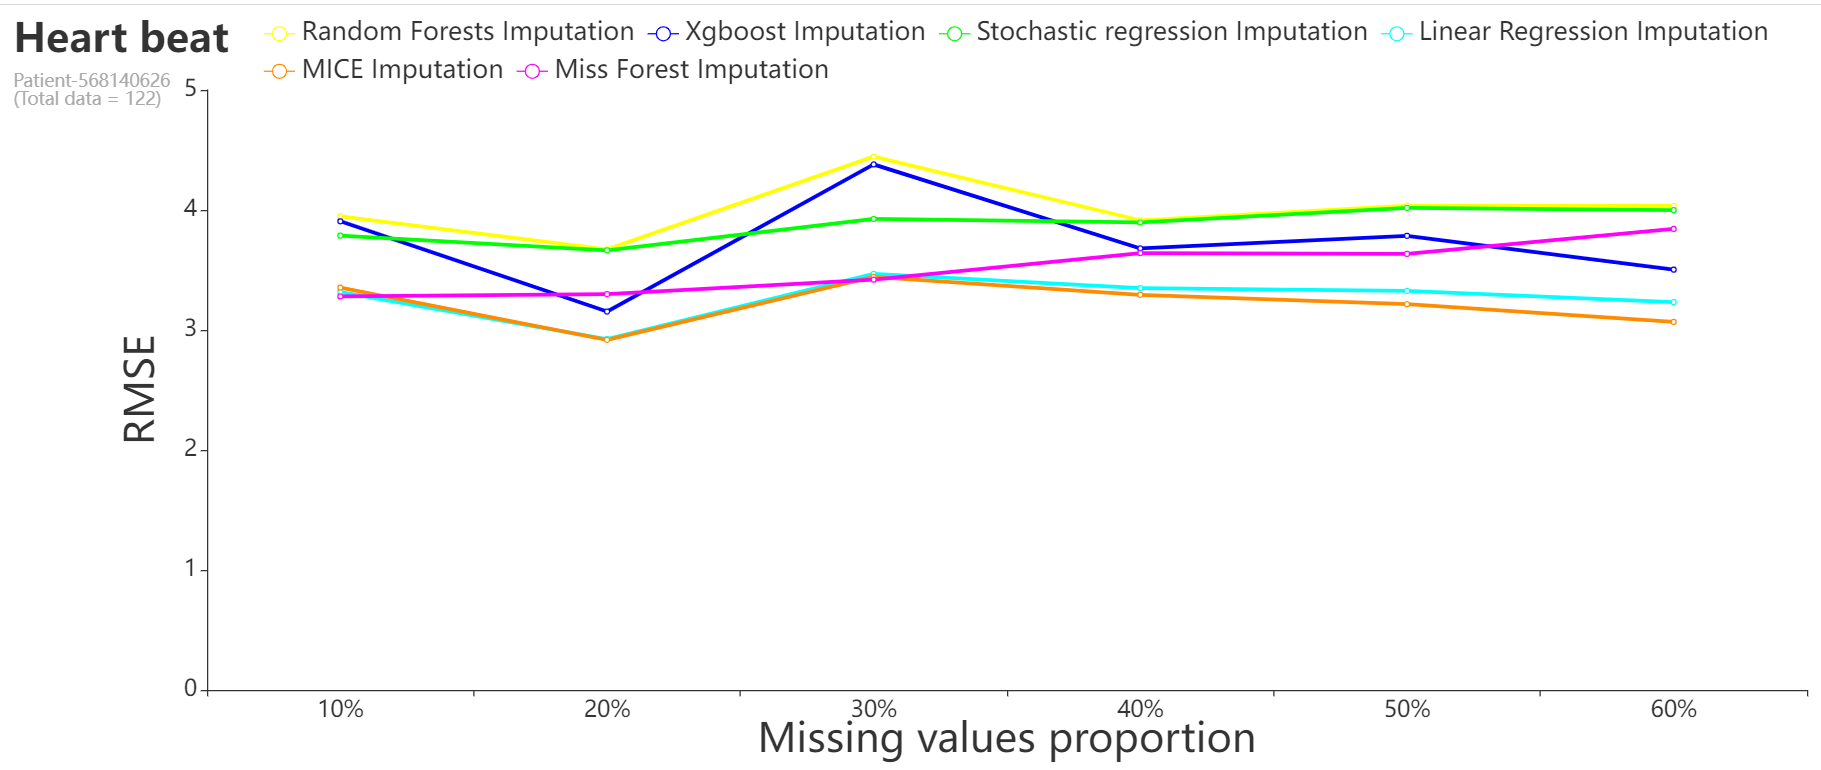

##Absolute Error TOT Graph

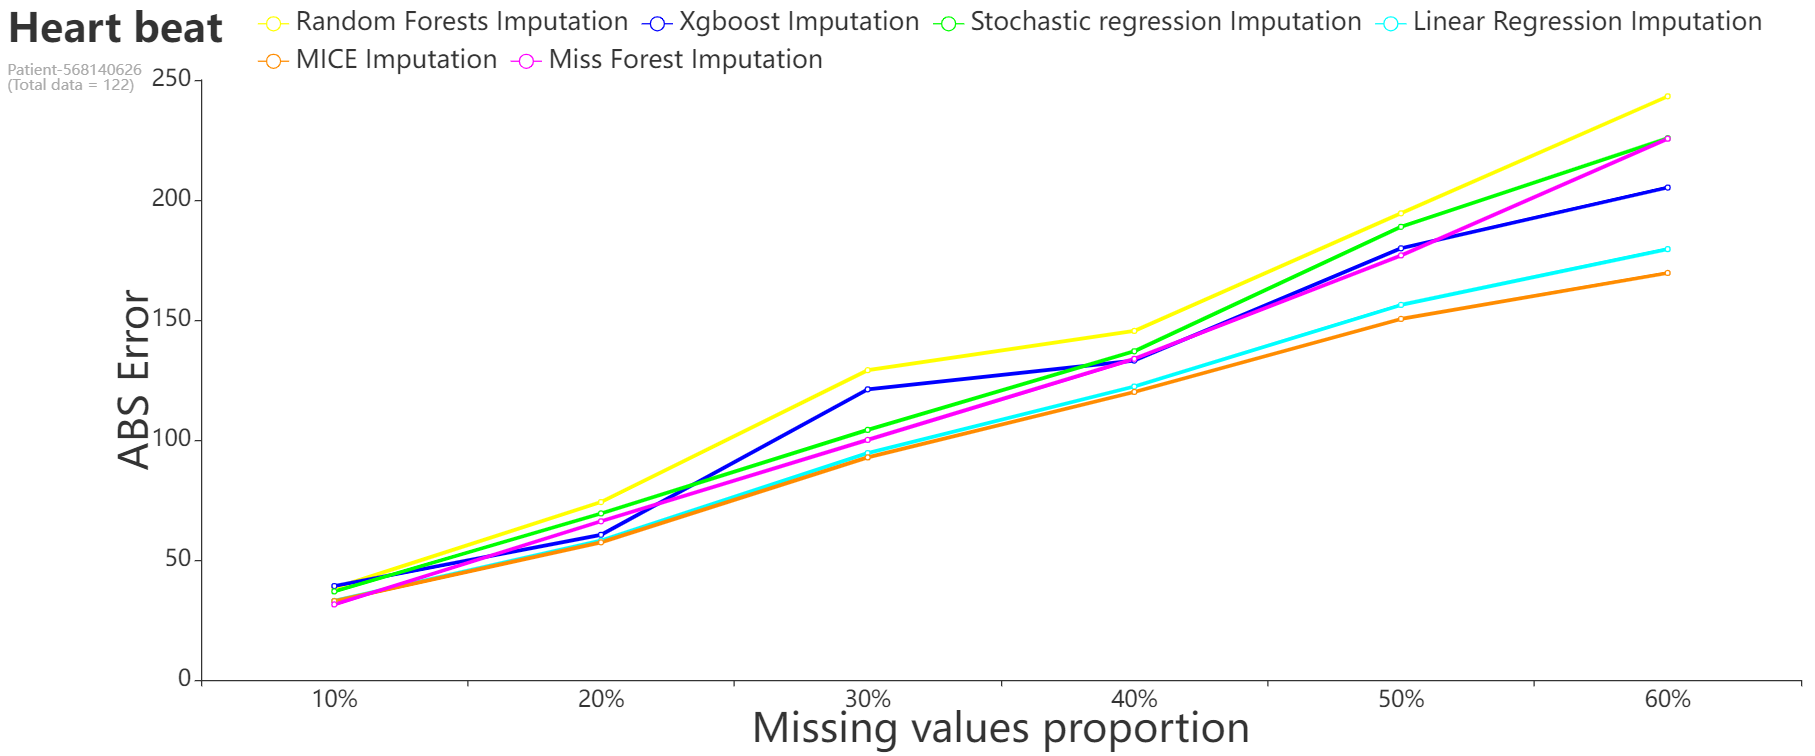

##MAE TOT Graph

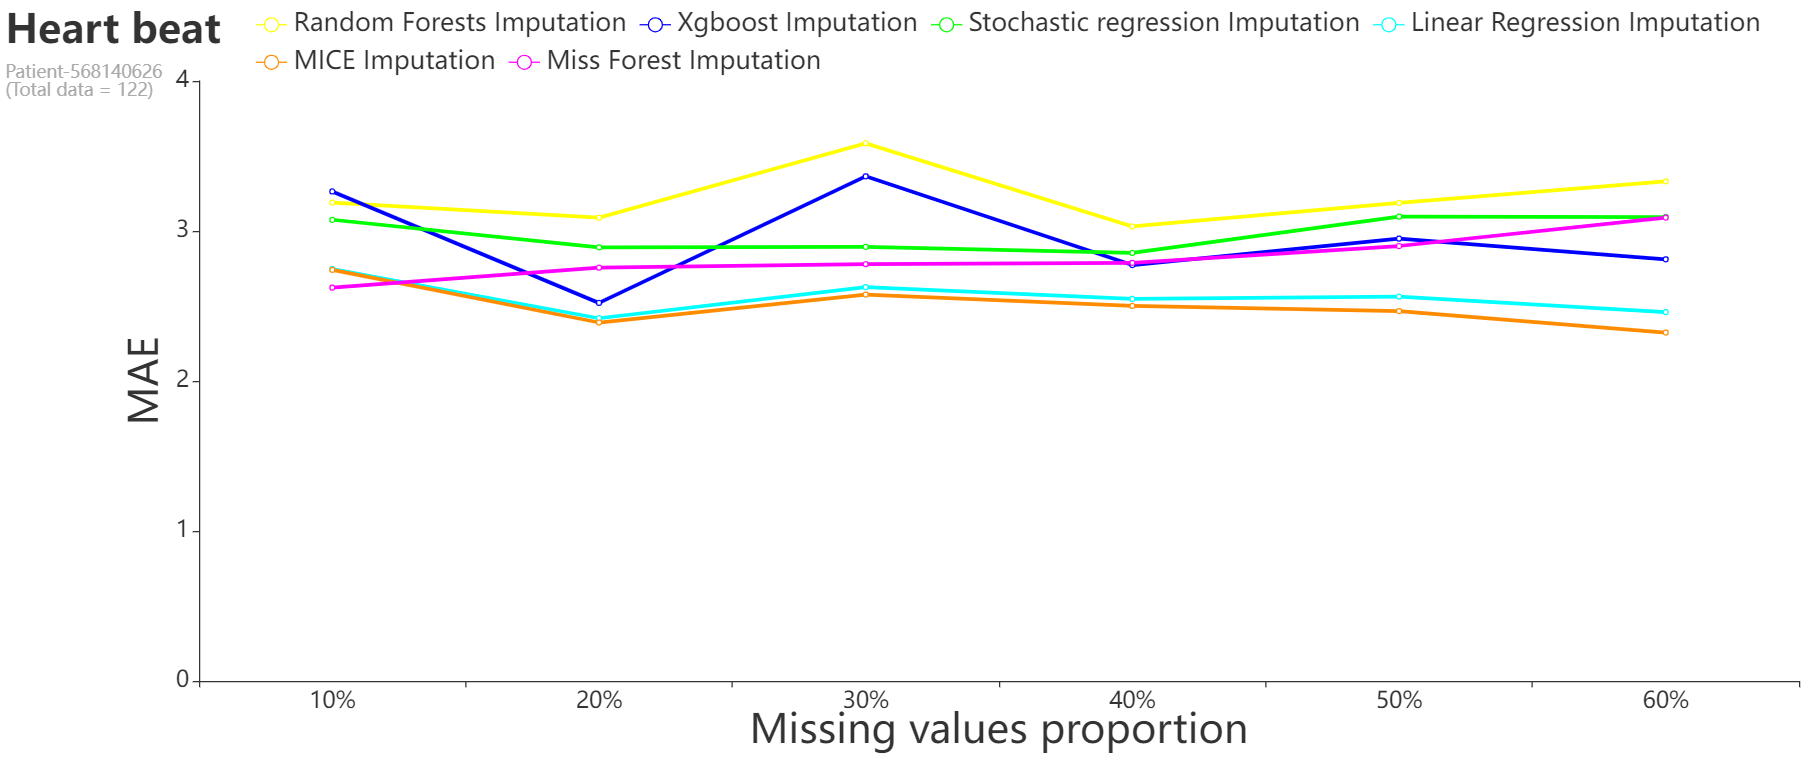

#PYECHARTS GRAPHS

##Data preparation for graphs

In [223]:
!pip install pyecharts -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [224]:
import pyecharts.options as opts
from pyecharts.charts import Line
import builtins

In [225]:
percRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'Linear Regression imputation']['Percentage of missing data'])
regRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'Linear Regression imputation']['RMSE'])
forRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'Random Forests Imputation']['RMSE'])
stoRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'Stochastic Regression Imputation']['RMSE'])
xgbRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'xgboostImputation']['RMSE'])
miceRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'MICE Imputation']['RMSE'])
missRMSE = list(dfRMSETOT1.loc[dfRMSETOT1['imputation method'] == 'Miss Forest Imputation']['RMSE'])

In [226]:
regABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Linear Regression imputation']['ABS Error'])
forABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Random Forests Imputation']['ABS Error'])
stoABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Stochastic Regression Imputation']['ABS Error'])
xgbABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'xgboostImputation']['ABS Error'])
miceABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'MICE Imputation']['ABS Error'])
missABS = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Miss Forest Imputation']['ABS Error'])

In [227]:
regMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Linear Regression imputation']['MAE'])
forMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Random Forests Imputation']['MAE'])
stoMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Stochastic Regression Imputation']['MAE'])
xgbMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'xgboostImputation']['MAE'])
miceMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'MICE Imputation']['MAE'])
missMAE = list(dfABSTOT.loc[dfABSTOT['imputation method'] == 'Miss Forest Imputation']['MAE'])

In [228]:
from pyecharts.options.series_options import LabelOpts, ItemStyleOpts, LineStyleOpts
from pyecharts.options.global_options import DataZoomOpts
from pyecharts.types import DataZoom
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.charts import Scatter

## Root Mean Square Error (RMSE) 

In [229]:
(
    Line(init_opts=opts.InitOpts(width="1600px", height="600px"))
    .add_xaxis(percRMSE)
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "yellow"),
        series_name="Random Forests Imputation",
        y_axis= forRMSE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Xgboost Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "blue"),
        y_axis= xgbRMSE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Stochastic regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "lime"),
        y_axis= stoRMSE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Linear Regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#00ffff"),
        y_axis= regRMSE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="MICE Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff8c00"),
        y_axis= miceRMSE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Miss Forest Imputation",
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff00ff"),
        linestyle_opts=opts.LineStyleOpts(width = 3),
        y_axis= missRMSE
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Heart beat", subtitle="Patient-568140626\n(Total data = 122)",\
                                  title_textstyle_opts=opts.TextStyleOpts(font_size=32),\
                                  subtitle_textstyle_opts=opts.TextStyleOpts(font_size=14)),
        xaxis_opts=opts.AxisOpts(name="Missing values proportion", name_gap = 25, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),\
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        yaxis_opts=opts.AxisOpts(name="RMSE", name_gap = 35, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        legend_opts=opts.LegendOpts(pos_left=200,textstyle_opts=opts.TextStyleOpts(font_size = 20))
    )
    .render("/content/drive/MyDrive/Tesi/RootMeanSquareErrorHeartbeat")
)

'/content/drive/MyDrive/Tesi/RootMeanSquareErrorHeartbeat'

 ## Absolute Error 

In [230]:
(
    Line(init_opts=opts.InitOpts(width="1600px", height="600px"))
    .add_xaxis(percRMSE)
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "yellow"),
        series_name="Random Forests Imputation",
        y_axis= forABS
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        linestyle_opts=opts.LineStyleOpts(width = 3),
        series_name="Xgboost Imputation",
        itemstyle_opts=opts.ItemStyleOpts(color = "blue"),
        y_axis= xgbABS
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Stochastic regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "lime"),
        y_axis= stoABS
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Linear Regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#00ffff"),
        y_axis= regABS
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="MICE Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff8c00"),
        y_axis= miceABS
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Miss Forest Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff00ff"),
        y_axis= missABS
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Heart beat", subtitle="Patient-568140626\n(Total data = 122)",\
                                  title_textstyle_opts=opts.TextStyleOpts(font_size=32),\
                                  subtitle_textstyle_opts=opts.TextStyleOpts(font_size=12)),
        xaxis_opts=opts.AxisOpts(name="Missing values proportion", name_gap = 25, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),\
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        yaxis_opts=opts.AxisOpts(name="ABS Error", name_gap = 35, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        legend_opts=opts.LegendOpts(pos_left=200,textstyle_opts=opts.TextStyleOpts(font_size = 20))
    )
    .render("/content/drive/MyDrive/Tesi/AbsoluteErrorHeartbeat")
)

'/content/drive/MyDrive/Tesi/AbsoluteErrorHeartbeat'

##Mean Absolute Error (MAE) 

In [231]:

(
    Line(init_opts=opts.InitOpts(width="1600px", height="600px"))
    .add_xaxis(percRMSE)
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        itemstyle_opts=opts.ItemStyleOpts(color = "yellow"),
        linestyle_opts=opts.LineStyleOpts(width = 3),
        series_name="Random Forests Imputation",
        y_axis= forMAE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Xgboost Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "blue"),
        y_axis= xgbMAE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Stochastic regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "lime"),
        y_axis= stoMAE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Linear Regression Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#00ffff"),
        y_axis= regMAE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="MICE Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff8c00"),
        y_axis= miceMAE
    )
    .add_yaxis(
        label_opts = opts.LabelOpts(is_show=False),
        series_name="Miss Forest Imputation",
        linestyle_opts=opts.LineStyleOpts(width = 3),
        itemstyle_opts=opts.ItemStyleOpts(color = "#ff00ff"),
        y_axis= missMAE
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Heart beat", subtitle="Patient-568140626\n(Total data = 122)",\
                                  title_textstyle_opts=opts.TextStyleOpts(font_size=32),\
                                  subtitle_textstyle_opts=opts.TextStyleOpts(font_size=14)),
        xaxis_opts=opts.AxisOpts(name="Missing values proportion", name_gap = 25, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),\
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        yaxis_opts=opts.AxisOpts(name="MAE", name_gap = 25, name_location = "center",\
                                 name_textstyle_opts=opts.TextStyleOpts(font_size = 32),
                                 axislabel_opts=opts.LabelOpts(font_size = 18)),
        legend_opts=opts.LegendOpts(pos_left=200,textstyle_opts=opts.TextStyleOpts(font_size = 20))
    )
    .render("/content/drive/MyDrive/Tesi/MAEHeartbeat")
)

'/content/drive/MyDrive/Tesi/MAEHeartbeat'